# SOGOS Main Glider Processing


Notes -  
Updated 10.04.22:
- Added oxygen lag correction.
- Now gp/gi "oxygen_raw" will contain old oxygen. and "oxygen" will hold corrected

Updated 09.10.22:
- Most recent variables under *_0910.nc -- pre-optode adjustment
- New version of main glider processing now uses L3 datasets.
- Most functions are found in sgmodule_*.py, and these cells are examples of what to run in terminal.

---
**Modules**

                sgmod_main as sg                      ytd, profile splitting... 
                sgmod_L3proc as gproc                 grid Xarray processing - buoyancy, AOU, transform, dav-BFSLE
                sgmod_DFproc as dfproc                DataFrame processing - season, dav-MLD, T-S binning, ESPER
                sgmod_plotting as sgplot              plotting functions 

---
**Data/Variable Names**
    
*Satellite:*    
 
                fsle_backwards                  map of daily FSLE snapshots
                satellite_data                  adt, geo velocities, ssh anomalies 
*Glider:*    
 
                gp_659                          L3 dataset gridded on pressure
                gi_659                          L3 dataset gridded on isopycnals
                dav_659                         L3 dive-averaged metrics, incl. MLD
                df_659                          Flattened dataframe for variable operations
    
 

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm as cmo
from datetime import datetime
import scipy
import seaborn as sns
# import glidertools as gt

# import importlib
# import sgmod_main as sg
# import sgmod_L3proc as gproc     # for L3 grid processing
# import sgmod_DFproc as dfproc    # for dataframe processing
# import sgmod_plotting as sgplot  


In [2]:
# Ship Data
file_path = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/go-ship/'
shipDF = pd.read_csv(file_path + '325020190403_ship_qc_sep2023.csv', index_col=[0])
shipDF = shipDF[shipDF["pressure"] < 1000] 
shipDF = shipDF.reset_index(drop = True)

In [3]:
# Float Data
# file_path = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/go-bgc/'
# float_data = pd.read_csv(file_path + 'argo_qc_9float_0915.csv', index_col=[0])
file_path = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/RF-training/'
float_data = pd.read_csv(file_path + 'mldata_floatDF_RF_ver19.csv', index_col=[0])

float_data = float_data[float_data["pressure"] < 1000]
float_data = float_data.reset_index(drop = True)

# Exclude chosen floats.
# Float selection is done in sogos_float_processing.ipynb.
wmo_list = pd.unique(float_data.wmoid)
excluded_floats = [] # 5906032, 5906035, 5906036]
wmoids = [x for x in wmo_list if x not in excluded_floats]

floatDF = float_data[~float_data['wmoid'].isin(excluded_floats)] # 9 floats

In [5]:
gp_660

NameError: name 'gp_660' is not defined

In [42]:
gp_660.where(gp_660.nprof==695)

<xarray.Dataset>
Dimensions:     (depth: 1001, nprof: 1008)
Coordinates:
  * nprof       (nprof) int64 0 1 2 3 4 5 6 ... 1008 1009 1010 1011 1012 1013
  * depth       (depth) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables: (12/16)
    time        (depth, nprof) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT
    dive        (nprof) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    lat         (depth, nprof) float32 nan nan nan nan nan ... nan nan nan nan
    lon         (depth, nprof) float32 nan nan nan nan nan ... nan nan nan nan
    speed       (depth, nprof) float32 nan nan nan nan nan ... nan nan nan nan
    P           (depth, nprof) float32 nan nan nan nan nan ... nan nan nan nan
    ...          ...
    bbp470      (depth, nprof) float32 nan nan nan nan nan ... nan nan nan nan
    bbp700      (depth, nprof) float32 nan nan nan nan nan ... nan nan nan nan
    sigma       (depth, nprof) float64 nan nan nan nan nan ... nan nan nan nan
    days        (depth, nprof) float64 nan nan nan nan nan ... nan nan nan nan
    buoyancy    (depth, nprof) float64 nan nan nan nan nan ... nan nan nan nan
    oxygen      (depth, nprof) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/49)
    id:                              sg660_level3
    time_coverage_resolution:        PT1S
    geospatial_vertical_units:       meter
    geospatial_vertical_resolution:  meter
    geospatial_vertical_positive:    no
    platform:                        glider
    ...                              ...
    time_coverage_duration:          P0000-00-208T14:40:52
    geospatial_vertical_min:         0.00
    geospatial_vertical_max:         1000.00
    date_created:                    2021-09-24T17:43:21Z
    date_modified:                   2021-09-24T17:43:21Z
    uuid:                            e93b1778-1d5e-11ec-9f9a-acde48001122

In [2]:
# Initial APL Glider data
file_path = '/Users/sangminsong/OneDrive-UW/Code/SOGOS-ML/data/seaglider-APL/'
L3_659 = xr.open_dataset(file_path + 'sg659_level3.nc')
L3_660 = xr.open_dataset(file_path + 'sg660_level3.nc')

In [3]:
L3_660

<xarray.Dataset>
Dimensions:                            (half_profile_data_point: 1082,
                                        z_data_point: 1001, dive_data_point: 541)
Dimensions without coordinates: half_profile_data_point, z_data_point,
                                dive_data_point
Data variables: (12/53)
    time                               (half_profile_data_point, z_data_point) datetime64[ns] ...
    S                                  (half_profile_data_point, z_data_point) float32 ...
    T                                  (half_profile_data_point, z_data_point) float32 ...
    speed                              (half_profile_data_point, z_data_point) float32 ...
    lat                                (half_profile_data_point, z_data_point) float32 ...
    lon                                (half_profile_data_point, z_data_point) float32 ...
    ...                                 ...
    u_dive                             (dive_data_point) float32 ...
    v_dive                             (dive_data_point) float32 ...
    surface_curr_east                  (dive_data_point) float32 ...
    surface_curr_north                 (dive_data_point) float32 ...
    lat_dive                           (dive_data_point) float32 ...
    lon_dive                           (dive_data_point) float32 ...
Attributes: (12/49)
    id:                              sg660_level3
    time_coverage_resolution:        PT1S
    geospatial_vertical_units:       meter
    geospatial_vertical_resolution:  meter
    geospatial_vertical_positive:    no
    platform:                        glider
    ...                              ...
    time_coverage_duration:          P0000-00-208T14:40:52
    geospatial_vertical_min:         0.00
    geospatial_vertical_max:         1000.00
    date_created:                    2021-09-24T17:43:21Z
    date_modified:                   2021-09-24T17:43:21Z
    uuid:                            e93b1778-1d5e-11ec-9f9a-acde48001122

In [7]:
# Initial APL Glider data
file_path = '/Users/sangminsong/OneDrive-UW/Code/SOGOS-ML/data/seaglider-APL/'
L2_659 = xr.open_dataset(file_path + 'sg659_level2.nc')
L2_660 = xr.open_dataset(file_path + 'sg660_level2.nc')

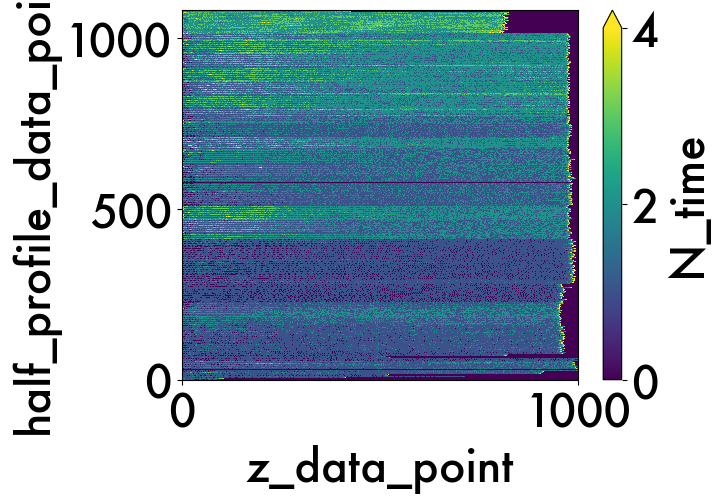

In [12]:
L2_660.N_time.plot(vmin=0, vmax=4)

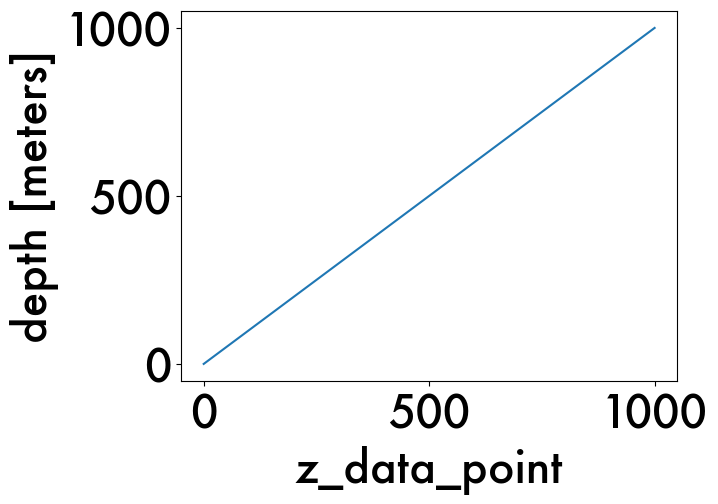

In [52]:
L2_660.z.plot()

In [1]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca()

L3_660.S.plot(ax=ax)
ax.set_xlim([20,40])
ax.set_ylim([0,50])

NameError: name 'plt' is not defined

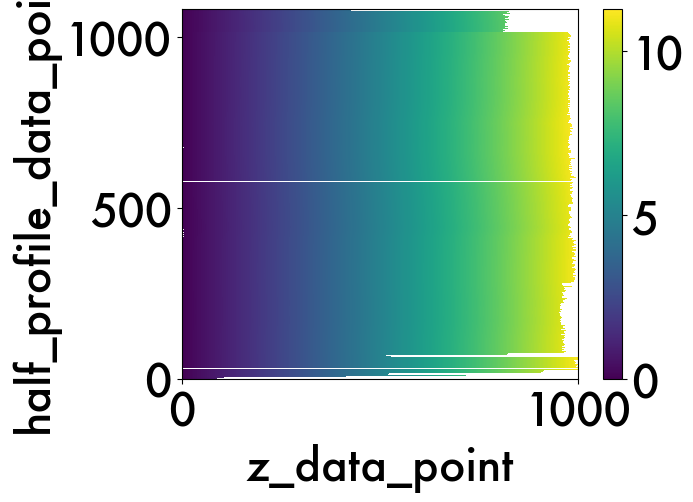

In [26]:
new = L3_660.P - L3_660.z
new.plot()

In [8]:
L2_660

<xarray.Dataset>
Dimensions:                      (half_profile_data_point: 1082,
                                  z_data_point: 1001, dive_data_point: 541)
Dimensions without coordinates: half_profile_data_point, z_data_point,
                                dive_data_point
Data variables: (12/25)
    time                         (half_profile_data_point, z_data_point) datetime64[ns] ...
    S                            (half_profile_data_point, z_data_point) float32 ...
    T                            (half_profile_data_point, z_data_point) float32 ...
    speed                        (half_profile_data_point, z_data_point) float32 ...
    lat                          (half_profile_data_point, z_data_point) float32 ...
    lon                          (half_profile_data_point, z_data_point) float32 ...
    ...                           ...
    u_dive                       (dive_data_point) float32 ...
    v_dive                       (dive_data_point) float32 ...
    surface_curr_east            (dive_data_point) float32 ...
    surface_curr_north           (dive_data_point) float32 ...
    lat_dive                     (dive_data_point) float32 ...
    lon_dive                     (dive_data_point) float32 ...
Attributes: (12/49)
    id:                              sg660_level2
    time_coverage_resolution:        PT1S
    geospatial_vertical_units:       meter
    geospatial_vertical_resolution:  meter
    geospatial_vertical_positive:    no
    platform:                        glider
    ...                              ...
    time_coverage_duration:          P0000-00-208T14:40:52
    geospatial_vertical_min:         0.00
    geospatial_vertical_max:         1000.00
    date_created:                    2021-09-24T17:43:21Z
    date_modified:                   2021-09-24T17:43:21Z
    uuid:                            e937ceb0-1d5e-11ec-9f9a-acde48001122

In [7]:
importlib.reload(gproc)

<module 'sgmod_L3proc' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/scripts/sgmod_L3proc.py'>

In [50]:
geo_659 = xr.open_dataset('/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS/data/sg659_earthcube/Chl_659.nc')

In [6]:
L3_659.wlbb2fl_sig470nm_adjusted

<xarray.DataArray 'wlbb2fl_sig470nm_adjusted' (half_profile_data_point: 984,
                                               z_data_point: 1001)>
[984984 values with dtype=float32]
Dimensions without coordinates: half_profile_data_point, z_data_point
Attributes:
    description:  total volume blue scattering coefficient using manufacturer...
    units:        meter^-1 steradian^-1

In [24]:
importlib.reload(gproc)

<module 'sgmod_L3proc' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/scripts/sgmod_L3proc.py'>

In [9]:
# Initial pressure-gridded dataset to perform corrections, calculate main variables.
gp_659 = gproc.simplify_grid(L3_659)
gp_660 = gproc.simplify_grid(L3_660)

# gp_659 = gproc.trim(gp_659, 0, 250)
# gp_660 = gproc.trim(gp_660, 0, 250)

In [ ]:
gp_659.buoyancy

In [14]:
g2_659 = gproc.simplify_grid(L2_659)
g2_660 = gproc.simplify_grid(L2_660)

KeyError: 'P'

In [ ]:
# def simplify_grid(L3):
#     """
#     Simplify L3 grid by removing unnecessary variables.
#     """
#     g3 = L3[['time', 'dive', 'lat', 'lon', 'speed', 
#              'P', 'SA', 'CT', 'dissolved_oxygen',
#              'wlbb2fl_sig695nm_adjusted', 'wlbb2fl_sig470nm_adjusted',
#              'wlbb2fl_sig700nm_adjusted']].copy() #700nm to match argo data
                           
#     g3["sigma"] = xr.DataArray(data=gsw.sigma0(g3.SA, g3.CT), dims=g3.dims)
#     g3['days'] = sg.datetime2ytd(g3.time)

#     # 'S':'salinity', 'T':'temperature', 
#     g3 = g3.rename({'dissolved_oxygen':'oxygen_raw'})
#     g3 = g3.rename({'wlbb2fl_sig700nm_adjusted':'bbp700'})
#     g3 = g3.rename({'wlbb2fl_sig695nm_adjusted':'bbp695'})
#     g3 = g3.rename({'wlbb2fl_sig470nm_adjusted':'bbp470'})
    
#     g3 = g3.rename_dims({'half_profile_data_point':'nprof', 'z_data_point':'depth'})

#     g3 = g3.transpose()   # avoids .T everytime you plot
#     g3 = g3.assign_coords({'nprof':g3.nprof.values, 'depth':g3.depth.values})


#     # drop off end dates from recovery period
#     # temp = g3.days.where(g3.days<300, drop=True)
#     # g3 = g3.sel(nprof=temp.nprof)
#     g3 = trim(g3, min=119, max=250, coord='days')

#     # g3 = add_AOU(g3)
#     g3 = Pchip_buoyancy(g3)

#     return g3

# 0. Data Corrections

- T-S Intercalibration: correct glider CT, SA offsets
- Oxygen optode lag correction
- Oxygen offset correction



## 0.0 Oxygen Lag

- Need to do this first before transforming to dataframe

In [9]:
# Prepare grids for optode lag correction if running for first time.
# Otherwise skip to next step.

def g3_optode_lag(g3):
    profiles = gproc.vert_profiles(g3)
    list=[]

    for profile in profiles:
        ind = ~np.isnan(profile.days.values)
        ytd_secs = profile.days.values[ind]*24*60*60
        depth = profile.depth.values[ind]

        secs = ytd_secs - ytd_secs[0]
        secs_row= np.empty(1001)
        secs_row[:] = np.nan

        for i, z in enumerate(depth):
            secs_row[z] = secs[i]

        list.append(secs_row)

    arr = np.array(list).T
    g3['secs'] = xr.DataArray(arr, dims = ["depth", "nprof"], 
                        coords = [g3.depth.values, g3.nprof.values] )
    return g3[['secs', 'oxygen_raw','CT']].copy()

opt659 = g3_optode_lag(gp_659)
opt660 = g3_optode_lag(gp_660)

file_path = '/Users/sangminsong/OneDrive-UW/Code/SOGOS-ML/working-vars/optode-lag/'
opt659.to_netcdf(file_path + 'optode_g659.nc')
opt660.to_netcdf(file_path + 'optode_g660.nc')

- In MATLAB, run Bittig function with threshold 0.75, blthickness=40 um
- Results saved in oxy_med

In [26]:
# After running in MATLAB: 
oxy_tcorr_659 = pd.read_csv('/Users/sangminsong/OneDrive-UW/Code/SOGOS-ML/working-vars/optode-lag/659-bl40-t75-oxymat_med.csv', header=None)
oxy_tcorr_660 = pd.read_csv('/Users/sangminsong/OneDrive-UW/Code/SOGOS-ML/working-vars/optode-lag/660-bl40-t75-oxymat_med.csv', header=None)

def inf2nan(obs_array):
    obs = obs_array.values
    obs[np.where(~np.isfinite(obs))] = np.NaN
    return obs

oxy_tcorr_659 = inf2nan(oxy_tcorr_659)
oxy_tcorr_660 = inf2nan(oxy_tcorr_660)

In [11]:
# if getting an error below, it means glider data wasn't trimmed
# gp_659 = gproc.trim(gp_659, 0, 250)
# gp_660 = gproc.trim(gp_660, 0, 250)

<module 'sgmod_L3proc' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/scripts/sgmod_L3proc.py'>

In [27]:
# # Adding new oxygen to gp dataset.
gp_659['oxygen'] = xr.DataArray(oxy_tcorr_659, dims = ["depth", "nprof"], 
                        coords = [gp_659.depth.values, gp_659.nprof.values] )
gp_660['oxygen'] = xr.DataArray(oxy_tcorr_660, dims = ["depth", "nprof"], 
                        coords = [gp_660.depth.values, gp_660.nprof.values] )

gp_659['oxygen'].attrs = {"description": "Time lag corrected with blthickness = 40um, threshold 0.75",
                          "units": "umol/kg"}
gp_660['oxygen'].attrs = {"description": "Time lag corrected with blthickness = 40um, threshold 0.75",
                          "units": "umol/kg"} 


# # These are saved as:
# gp_659.to_netcdf('/Users/sangminsong/OneDrive-UW/Code/SOGOS-ML/working-vars/glider/gp_659_OxyLagCorrected_0915.nc')
# gp_660.to_netcdf('/Users/sangminsong/OneDrive-UW/Code/SOGOS-ML/working-vars/glider/gp_660_OxyLagCorrected_0915.nc')


# gp_659['oxy_med'] = xr.DataArray(inf2nan(oxy_med), dims = ["depth", "nprof"], coords = [gp.depth.values, gp.nprof.values] )

In [12]:
importlib.reload(dfproc)

<module 'sgmod_DFproc' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/scripts/sgmod_DFproc.py'>

In [28]:
# Make dataframes
df_659=dfproc.flatten2DF(gp_659, nandrop=False)
df_660=dfproc.flatten2DF(gp_660, nandrop=False)

In [29]:
# Add profile ID's 
prof = df_659.profid.astype(str)
prof = [tag.zfill(4) for tag in prof]
df_659['profid'] = ['659'+tag for tag in prof]

prof = df_660.profid.astype(str)
prof = [tag.zfill(4) for tag in prof]
df_660['profid'] = ['660'+tag for tag in prof]

## 0.1 Add T-S Intercalibration corrections.

- More details in `ts_calibration_diagnostics.ipynb>`

- See ts_calibration notebook for where these values came from

(glider - prediction) == so you will subtract these differences from the glider

- avg diff for 659 temperature: -0.14917059036423155
- avg diff for 659 salinity: 0.009041232097053951


- avg diff for 660 temperature: -0.02603317645270598
- avg diff for 660 salinity: 0.1863327812530914

In [30]:
# Updated values with same training floatDF from ver19, Oct 2023.
df_659['CT'] = df_659.CT + 0.07075811866719528
df_659['SA'] = df_659.SA + 0.0030325720992010474

df_660['CT'] = df_660.CT + 0.02977273687502624
df_660['SA'] = df_660.SA - 0.17977978726869281

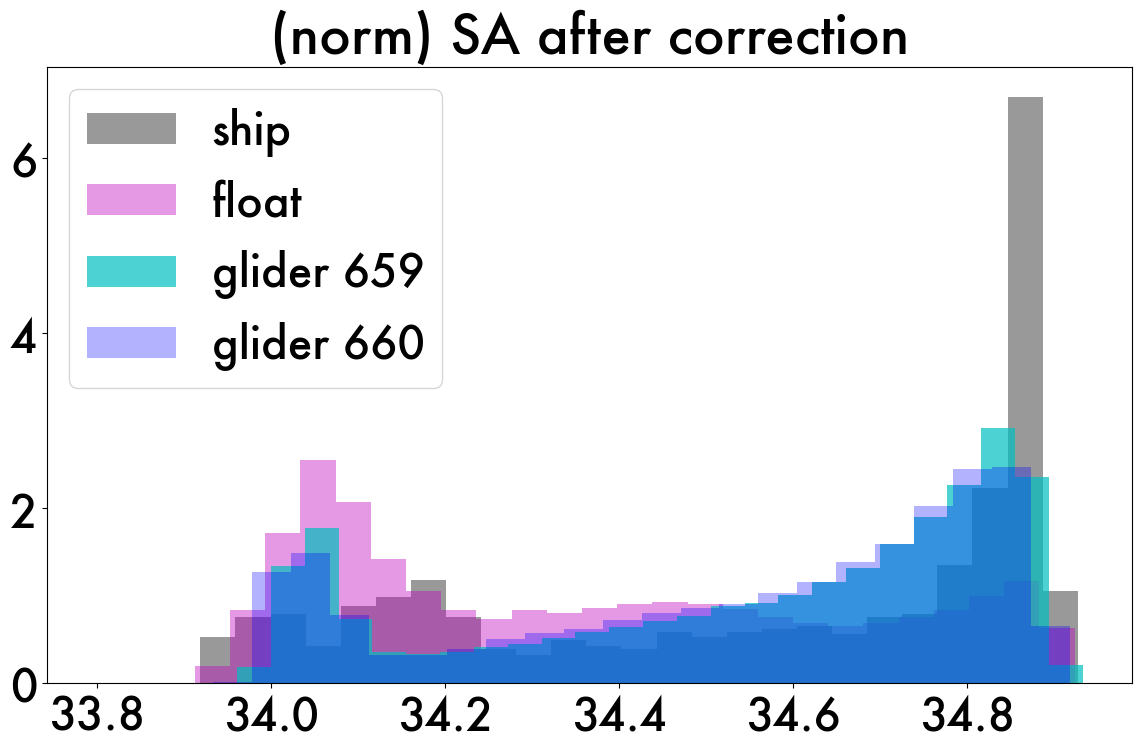

In [31]:
# Plot: Compare deep SA values
fig = plt.figure(figsize=(14,8))
plt.hist(shipDF.SA, bins=25, color='k', alpha=0.4, label="ship", density=True)
plt.hist(floatDF.SA, bins=25, color='m', alpha=0.4, label="float", density=True)
plt.title('(norm) SA after correction')

plt.hist(df_659.SA, bins=25, color='c', alpha=0.7, label="glider 659", density=True)
plt.hist(df_660.SA, bins=25, color='blue', alpha=0.3, label="glider 660", density=True)
# plt.hist(shipDF.nitrate, bins=25, color='k', alpha=0.4, label="ship")

# plt.hist(df_659.nitrate[200:70000:40], bins=25, color='k', alpha=0.9, label="glider (subset)")

plt.legend()

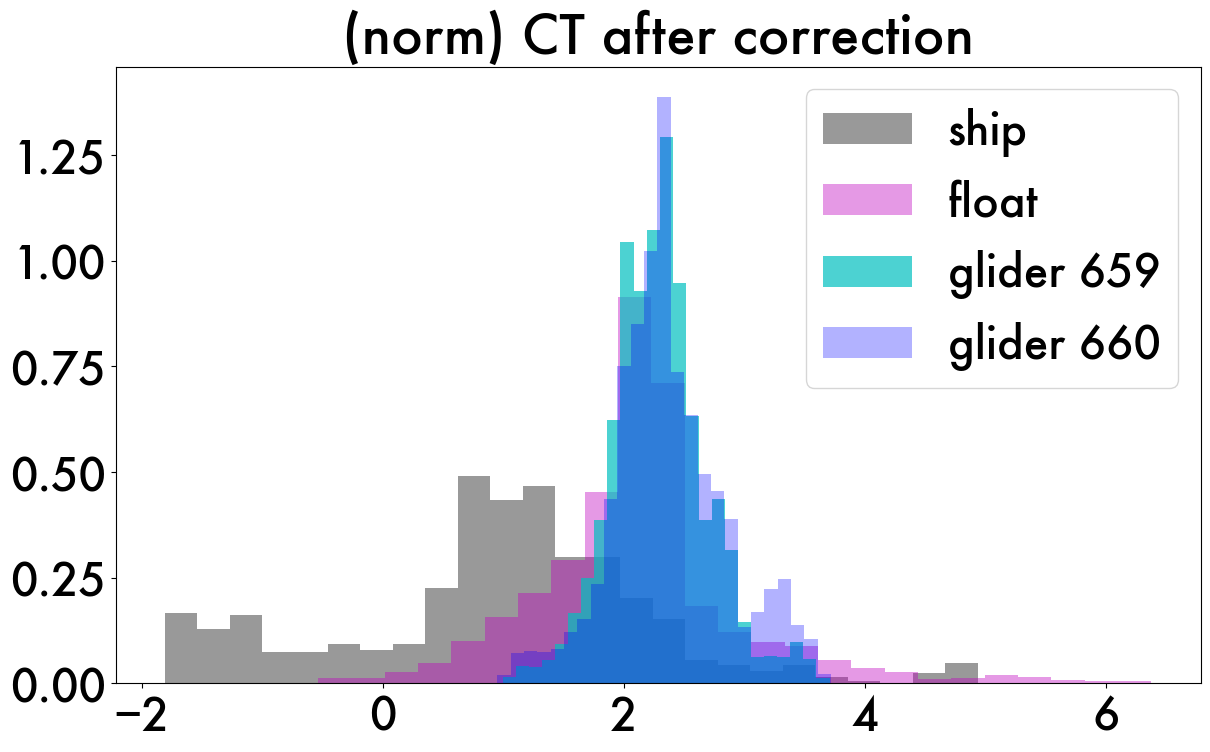

In [16]:
# Plot: Compare deep CT values
fig = plt.figure(figsize=(14,8))
plt.hist(shipDF.CT, bins=25, color='k', alpha=0.4, label="ship", density=True)
plt.hist(floatDF.CT, bins=25, color='m', alpha=0.4, label="float", density=True)
plt.title('(norm) CT after correction')

plt.hist(df_659.CT, bins=25, color='c', alpha=0.7, label="glider 659", density=True)
plt.hist(df_660.CT, bins=25, color='blue', alpha=0.3, label="glider 660", density=True)
# plt.hist(shipDF.nitrate, bins=25, color='k', alpha=0.4, label="ship")

# plt.hist(df_659.nitrate[200:70000:40], bins=25, color='k', alpha=0.9, label="glider (subset)")

plt.legend()

## 0.1 Oxygen gain correction from floats

glider 659 oxygen gain:

                slope: 1.1257536686711107
                intercept: -3.256610828316184
                r_value2: 0.9729785581579861
                p_value: 4.266443322182097e-88
                std_err: 0.01788750025545505


glider 660 oxygen gain:

                slope: 1.086592098354594
                intercept: -0.14620781346087597
                r_value2: 0.974386099793598
                p_value: 5.2170706031613036e-189
                std_err: 0.01149224637671065

In [65]:
import gsw

In [32]:
# Correct oxygen using gain function
# Use SG_Glider_Calibration_Diagnostics.ipynb for these values
# Updated Sep 2023
oxygen_gain_659 = lambda x: x * 1.127595835586986 -2.4421129321153785
oxygen_gain_660 = lambda x: x * 1.088941226921577 + 0.31446023222429176

df_659 = df_659.assign(oxygen = oxygen_gain_659(df_659['oxygen']))
df_660 = df_660.assign(oxygen = oxygen_gain_660(df_660['oxygen']))

In [33]:
# Add AOU using corrected O2, CT, SA
import gsw
df_659['AOU'] = gsw.O2sol(df_659['SA'], df_659['CT'], df_659['pressure'], df_659['lon'], df_659['lat']) - df_659['oxygen']
df_660['AOU'] = gsw.O2sol(df_660['SA'], df_660['CT'], df_660['pressure'], df_660['lon'], df_660['lat']) - df_660['oxygen']

# Add O2 sat
df_659['o2sat'] = gsw.O2sol(df_659['SA'], df_659['CT'], df_659['pressure'], df_659['lon'], df_659['lat'])
df_660['o2sat'] = gsw.O2sol(df_660['SA'], df_660['CT'], df_660['pressure'], df_660['lon'], df_660['lat'])

In [34]:
# Add log buoyancy 
df_659['log_buoyancy'] = np.log(df_659['buoyancy'])
df_660['log_buoyancy'] = np.log(df_660['buoyancy'])

# df_659 = dfproc.add_dist2maxb(df_659)
# df_660 = dfproc.add_dist2maxb(df_660)

/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
# Plotting parameters
size = 22
params = {'legend.fontsize': size-4, 
          'xtick.labelsize':size, 
          'ytick.labelsize':size, 
          'font.size':size,
          'font.family':'Futura'}
plt.rcParams.update(params)

# Set up WMO colors
pal = sns.color_palette("Paired")
wmo_colors = dict.fromkeys(floatDF.wmoid.unique())
for i, wmo in enumerate(floatDF.wmoid.unique()):
    wmo_colors[wmo] = pal[i]
wmo_colors[5906035]=sns.color_palette("Dark2")[3]
wmo_colors[5906036]=sns.color_palette("Dark2")[0]

Text(0, 0.5, 'density')

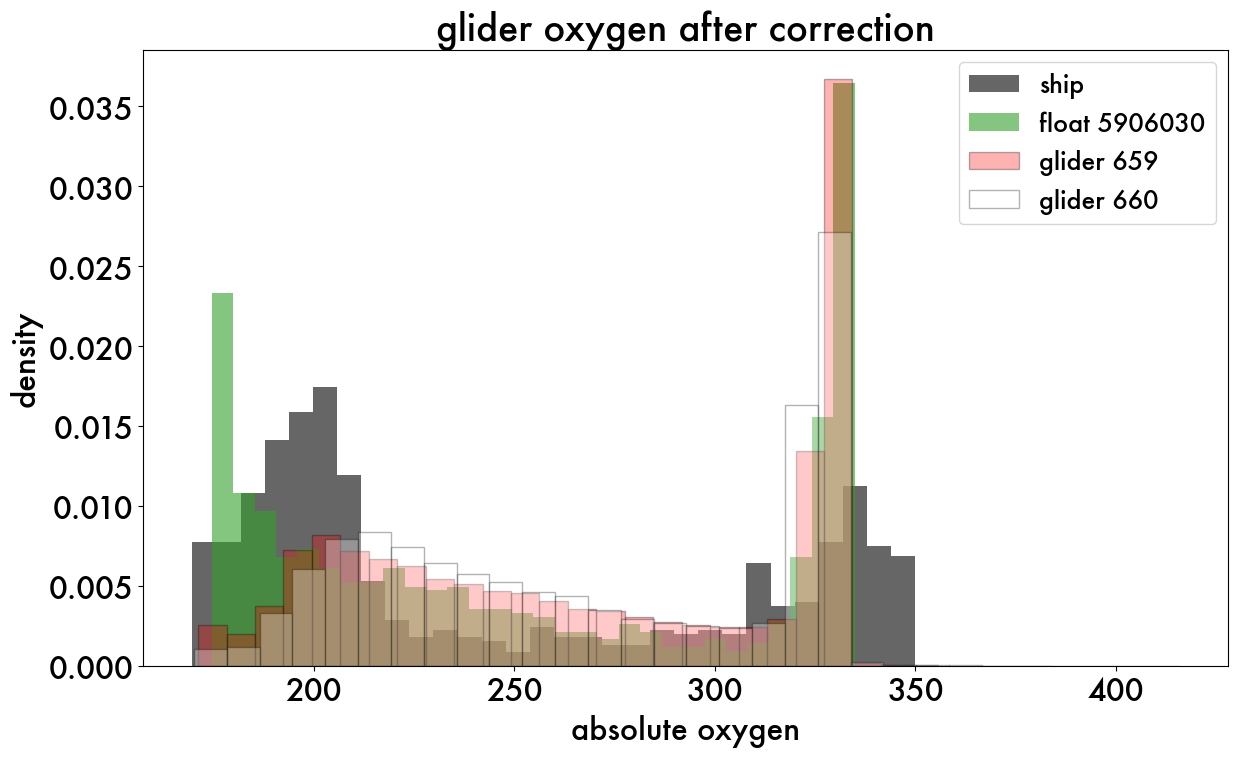

In [21]:
# compare deep oxygen values

fig = plt.figure(figsize=(14,8))
plt.hist(shipDF.oxygen, bins=30, color='k', alpha=0.6, label="ship", density=True)

flodat = floatDF[floatDF.wmoid==5906030]
plt.hist(flodat[flodat.yearday<200].oxygen, bins=30, color=wmo_colors[5906030], alpha=0.6, label="float 5906030", density=True)
# plt.hist(floatDF.oxygen, bins=30, color='orange', alpha=0.4, label="all other flots", density=True)
plt.title('glider oxygen after correction')

plt.hist(df_659.oxygen, bins=30, color='r', alpha=0.3, label="glider 659", density=True, edgecolor='k')
plt.hist(df_660.oxygen, bins=30, color='w', alpha=0.3, label="glider 660", density=True, edgecolor='k')


plt.legend()
plt.xlabel('absolute oxygen')
plt.ylabel('density')

Text(0, 0.5, 'density')

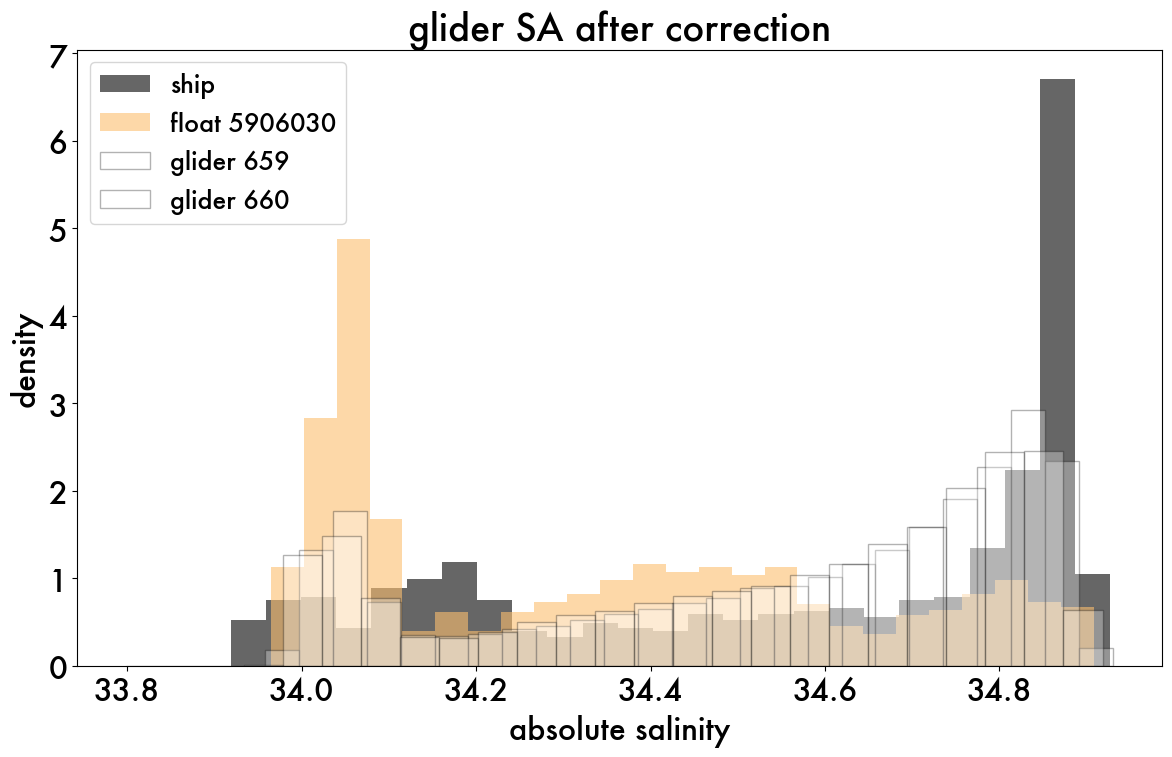

In [40]:
# compare deep SA values

fig = plt.figure(figsize=(14,8))
plt.hist(shipDF.SA, bins=25, color='k', alpha=0.6, label="ship", density=True)

flodat = floatDF[floatDF.wmoid==5906030]

plt.hist(flodat[flodat.yearday<200].SA, bins=25, color=wmo_colors[5906030], alpha=0.6, label="float 5906030", density=True)
# plt.hist(floatDF.SA, bins=25, color='orange', alpha=0.4, label="all other flots", density=True)
plt.title('glider SA after correction')

plt.hist(df_659.SA, bins=25, color='w', alpha=0.3, label="glider 659", density=True, edgecolor='k')
plt.hist(df_660.SA, bins=25, color='w', alpha=0.3, label="glider 660", density=True, edgecolor='k')


plt.legend()
plt.xlabel('absolute salinity')
plt.ylabel('density')


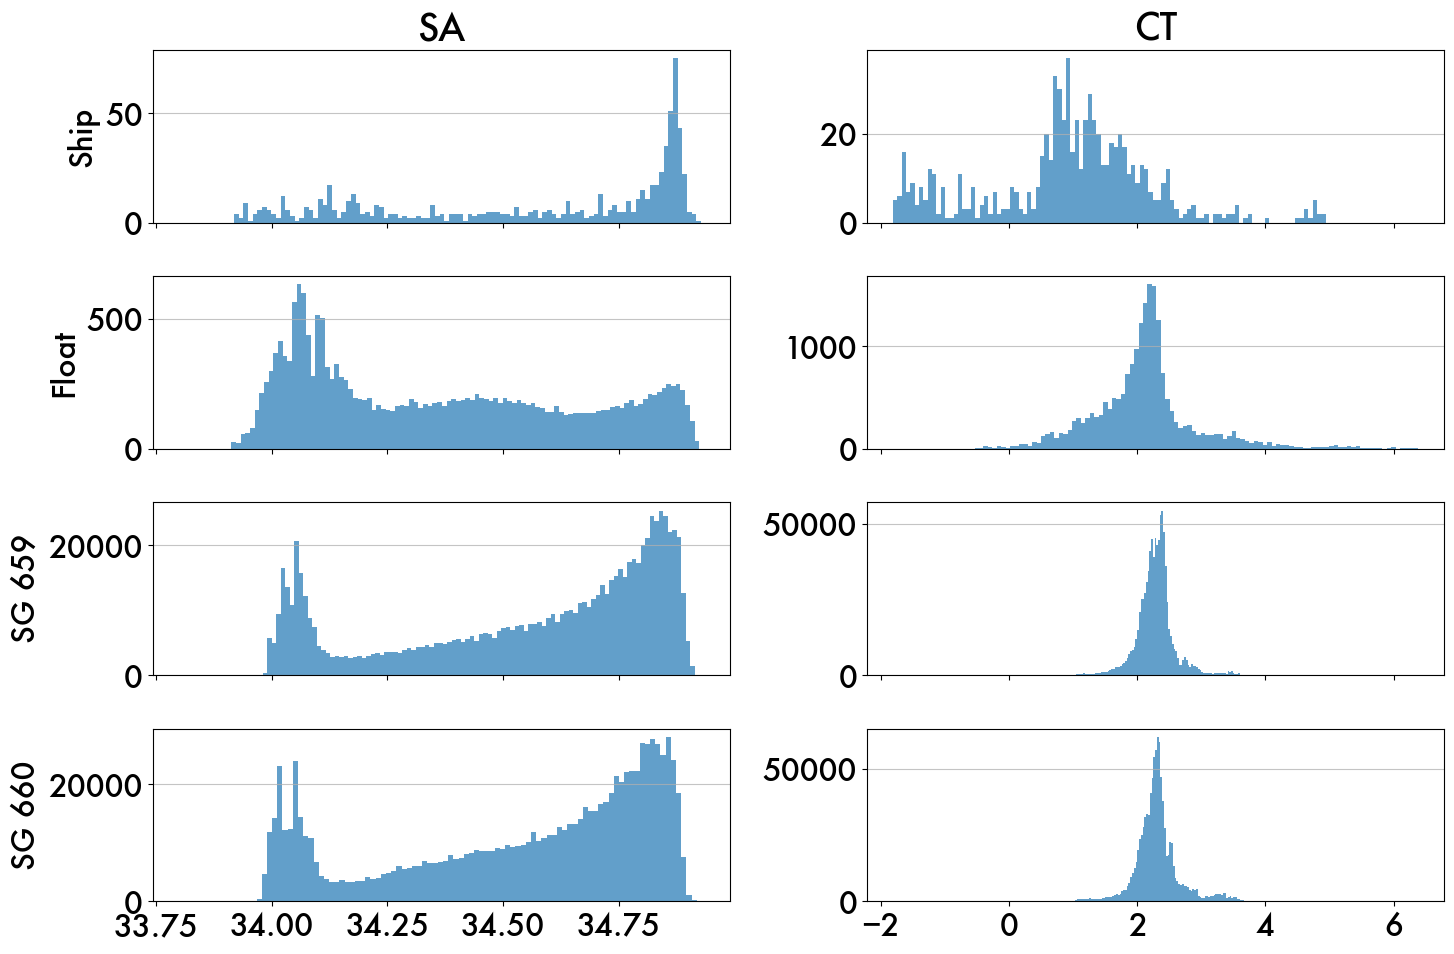

In [77]:
# Variable distributions from training ship/float data 
nbins = 100
fig, axs = plt.subplots(4, 2, figsize=(15, 10), tight_layout=True, sharex='col')
for c, var in enumerate(['SA', 'CT']):
    axs[0,c].hist(x=shipDF[var].values, bins=nbins, alpha=0.7)
    axs[1,c].hist(x=floatDF[var].values, bins=nbins, alpha=0.7)
    axs[2,c].hist(x=df_659[var].values, bins=nbins, alpha=0.7)
    axs[3,c].hist(x=df_660[var].values, bins=nbins, alpha=0.7)

    axs[0,c].set_title(var)

axs[0,0].set_ylabel('Ship')
axs[1,0].set_ylabel('Float')
axs[2,0].set_ylabel('SG 659')
axs[3,0].set_ylabel('SG 660')

for ax in axs.flatten():
    ax.grid(axis='y', alpha=0.75)

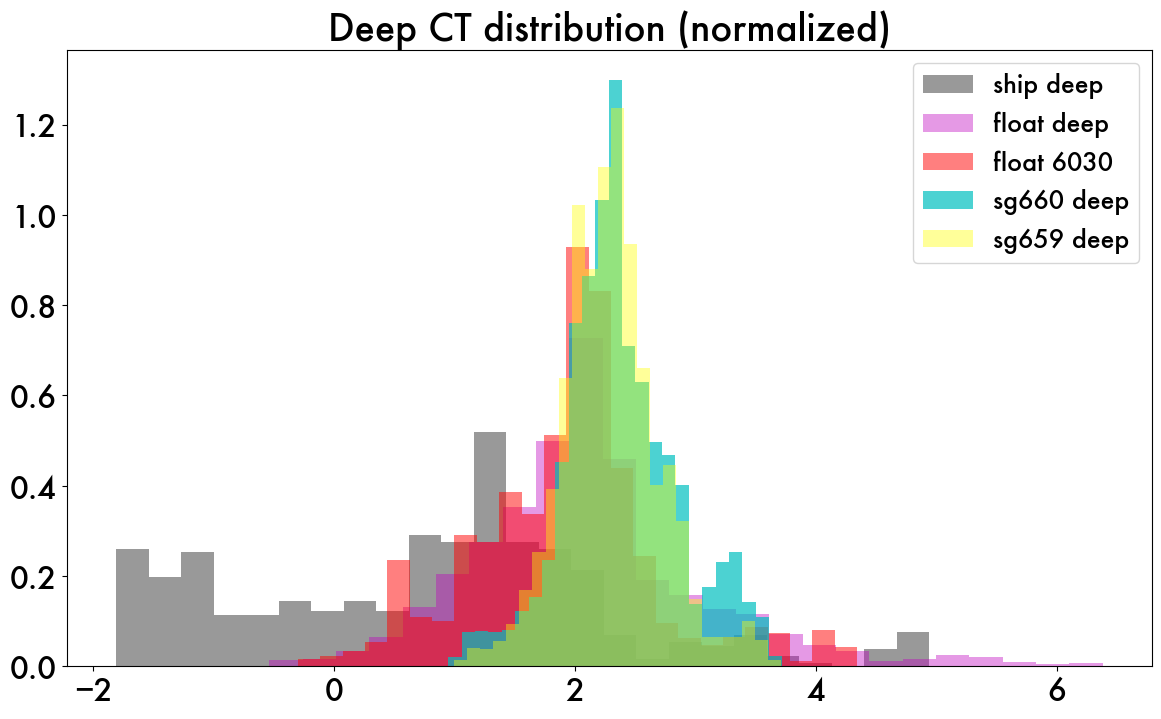

In [78]:
# compare deep CT values
threshold = 400

dship = shipDF[shipDF.pressure<threshold]
dfloat = floatDF[floatDF.pressure<threshold]
# dfloat = floatDF[(floatDF.wmoid == 5906030) & (floatDF.pressure<threshold)]
dglider = df_660[df_660.pressure<threshold]
dglider_659 = df_659[df_659.pressure<threshold]
fig = plt.figure(figsize=(14,8))

plt.hist(dship.CT, bins=25, color='k', alpha=0.4, label="ship deep", density=True)
plt.hist(dfloat.CT, bins=25, color='m', alpha=0.4, label="float deep", density=True)
plt.hist(dfloat[dfloat.wmoid == 5906030].CT, bins=25, color='r', alpha=0.5, label="float 6030", density=True)
plt.title('Deep CT distribution (normalized)')

plt.hist(dglider.CT, bins=25, color='c', alpha=0.7, label="sg660 deep", density=True)
plt.hist(dglider_659.CT, bins=25, color='yellow', alpha=0.4, label="sg659 deep", density=True)
# plt.hist(shipDF.nitrate, bins=25, color='k', alpha=0.4, label="ship")

# plt.hist(df_660.nitrate[200:70000:40], bins=25, color='k', alpha=0.9, label="glider (subset)")

plt.legend()

## 0.2 Oxygen Corrections

- More details in `<optode_lag_diagnostics.ipynb>`

## 0.3 Add variable attributes to clean up dataset readability.

In [ ]:
# var_units = {'SA': 'g/kg', 
#         'CT': cmo.thermal, 
#         'oxygen': cmo.ice, 
#         'oxy_tcorr': cmo.ice, 
#         # 'Chl': cmo.algae,
#         'AOU': cmo.amp, 
#         'pH': cmo.matter_r, 
#         'TA': cmo.tempo}

# SAVE DF for TRAINING

In [35]:
file_path = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/glider/'
df_659.to_csv(file_path + 'df_659_tsO2corr_nonandrop_0131.csv')
df_660.to_csv(file_path + 'df_660_tsO2corr_nonandrop_0131.csv')

NameError: name 'df_660' is not defined

Text(0, 0.5, 'pressure')

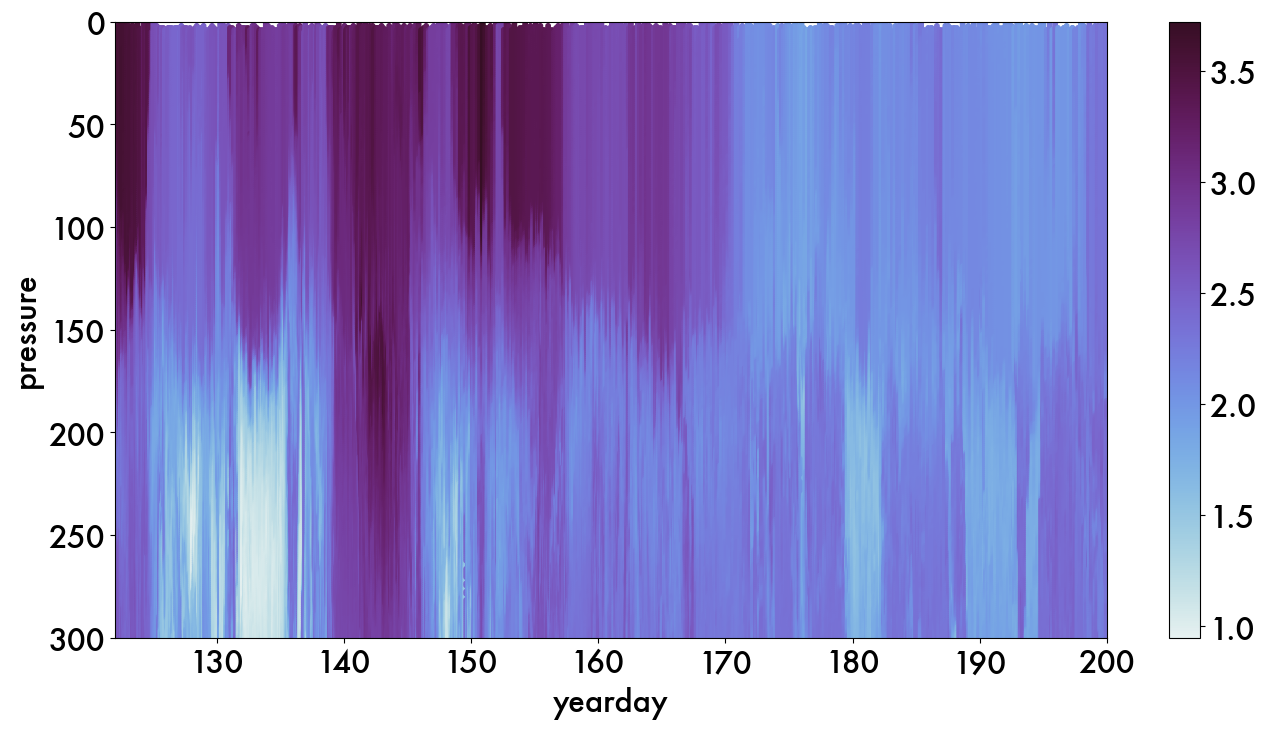

In [330]:
# Plot nitrate profile with MLD
fig = plt.figure(figsize=(16,8))
ax = fig.gca()

df_glid = full_df_660
dat = df_glid[df_glid.pressure<300]
dat = dat[(dat.yearday>121) & (dat.yearday<200)]


map = ax.scatter(dat.yearday, dat.pressure, c=dat.CT, cmap=cmo.dense, s=10)
plt.colorbar(map)

ax.invert_yaxis()
ax.set_xlim([122,200])
ax.set_ylim([300, 0])

ax.set_xlabel('yearday')
ax.set_ylabel('pressure')

# Figures

In [93]:

import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf    

In [89]:
dav_659 = xr.open_dataset('../working-vars/glider/dav_660_0910.nc') 
dav_659 = xr.open_dataset('../working-vars/glider/dav_659_0910.nc')

In [91]:
file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/'
fsle = xr.open_dataset(file_path + 'fsle_backwards.nc')
adt = xr.open_dataset(file_path + 'satellite_data.nc')

AttributeError: 'GeoAxesSubplot' object has no attribute '_autoscaleXon'

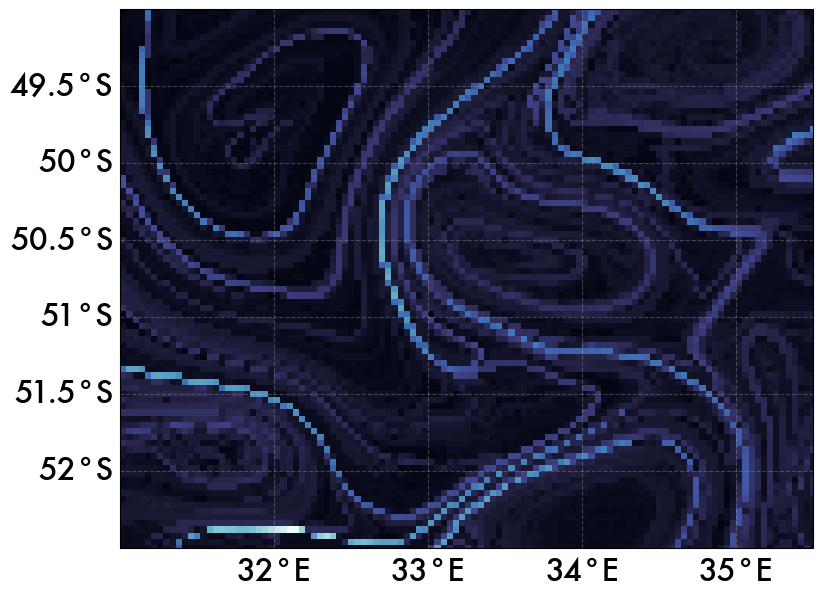

In [96]:
dav = dav_659
llcoords = [31,35.5,-52.5, -49]
# file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/scripts/working-figs/'
# fname = 'ADTstudyregion_2glider_path_yd'
savefig = False
# savefig = True

daylist = np.arange(145,146,1)
for day in daylist:
    fig = plt.figure(figsize=(10,7))


    dat = fsle.sel(time=sg.ytd2datetime(day))

    ax = plt.axes(projection=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent(llcoords)

    map = dat.fsle_max.plot(cmap=cmo.ice_r, ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    plt.plot(dav_659.lon, dav_659.lat, linewidth=8, color='orange', alpha=0.9)
    i = np.where(dav_659.days.round()==day)
    plt.scatter(dav_659.lon[i], dav_659.lat[i], 140, color='w', label = '659')

    plt.title('surface strain')
    plt.ylabel('')
    plt.xlabel('')

    # cax = fig.add_axes([ax.get_position().x1+0.04,ax.get_position().y0+.04,0.03,ax.get_position().height*.9])
    # cbar = plt.colorbar(map, cax)
    # cbar.ax.tick_params(labelsize=28) 

plt.show()
plt.close()
# Image(file_path + fname + str(120) + '.png') 

# 1. Gridded Variables in Pressure Space

- T, S, and O2 have been corrected in previous section 0. 
- gp_659 and gp_660 should contain calibrated, corrected variables which will be used for the Random Forest and ESPER predictions


## 1.1 (OUTDATED FEB 2023) Add SOML Estimates
- More details in `SOML_prediction.ipynb>`

In [13]:
file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/'
# ArrayDataDF = pd.read_csv(file_path + 'Unsplit_FloatShip_DF.csv')
training = pd.read_csv(file_path + 'SplitTraining_FloatShip_DF.csv')
test = pd.read_csv(file_path + 'SplitTest_FloatShip_DF.csv')
validation = pd.read_csv(file_path + 'SplitValidation_FloatShip_DF.csv')

In [14]:
# Machine Learning/Statistics Packages
from scipy.stats import kde
from scipy.stats import iqr
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb
# from pyGAM import LinearGAM, l, s, f

In [62]:
# Prepare dataset for prediction by turning into a 2D Dataframe
df_659=dfproc.flatten2DF(gp_659, add_Training=False)
df_660=dfproc.flatten2DF(gp_660, add_Training=False)

In [22]:
# Predict nitrate first (important feature for pH prediction)
ntrees = 1000
Mdl_nitrate = RandomForestRegressor(ntrees, max_features=1/3, oob_score = True, random_state = 0)
variable = 'Nitrate'
X_training = training[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", 
                        "Temperature", "Salinity", "Oxygen", "N_Squared_v2"]].to_numpy()
Y_training = training[variable].to_numpy()
Mdl_nitrate.fit(X_training, Y_training)

def predict_glider_nitrate(df_glider, Mdl):
    """
    Predicts glider data using the trained model"""

    X_glider = df_glider[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", 
                        "Temperature", "Salinity", "Oxygen", "N_Squared_v2"]].to_numpy()
    Y_pred_glider = Mdl.predict(X_glider)
    return Y_pred_glider


In [2]:
"Latitude"
"Longitude"
"Season(sin)"
"Season(cos)"
"Pressure"
"Temperature"
"Salinity"
"Oxygen"
"N_Squared_v2"



'N_Squared_v2'

In [23]:
df_659["Nitrate"] = predict_glider_nitrate(df_659, Mdl_nitrate)
df_660["Nitrate"] = predict_glider_nitrate(df_660, Mdl_nitrate)

In [24]:
gp_659['nitrate'] = dfproc.dfvar_to_darray(df_659, var='Nitrate')
gp_660['nitrate'] = dfproc.dfvar_to_darray(df_660, var='Nitrate')

In [25]:
# Predict pH. Note that we use the Nitrate output from previous cell. 
ntrees = 1000
Mdl_pH = RandomForestRegressor(ntrees, max_features=1/3, oob_score = True, random_state = 0)
variable = 'pH'
X_training = training[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", 
                        "Temperature", "Salinity", "Oxygen", "Nitrate", "N_Squared_v2"]].to_numpy()
Y_training = training[variable].to_numpy()
Mdl_pH.fit(X_training, Y_training)

def predict_glider_pH(df_glider, Mdl):
    """
    Predicts glider data using the trained model"""

    X_glider = df_glider[["Latitude", "Longitude", "Season(sin)", "Season(cos)","Pressure", 
                        "Temperature", "Salinity", "Oxygen", "Nitrate", "N_Squared_v2"]].to_numpy()
    Y_pred_glider = Mdl.predict(X_glider)
    return Y_pred_glider


In [27]:
df_659["pH"] = predict_glider_pH(df_659, Mdl_pH)
df_660["pH"] = predict_glider_pH(df_660, Mdl_pH)

In [46]:
# gp_659['pH'] = dfproc.dfvar_to_darray(df_659, var='pH')
# gp_660['pH'] = dfproc.dfvar_to_darray(df_660, var='pH')

# file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/'
# gp_659.to_netcdf(file_path + 'gp_659_nitrate_pH_1013.nc')
# gp_660.to_netcdf(file_path + 'gp_660_nitrate_pH_1013.nc')


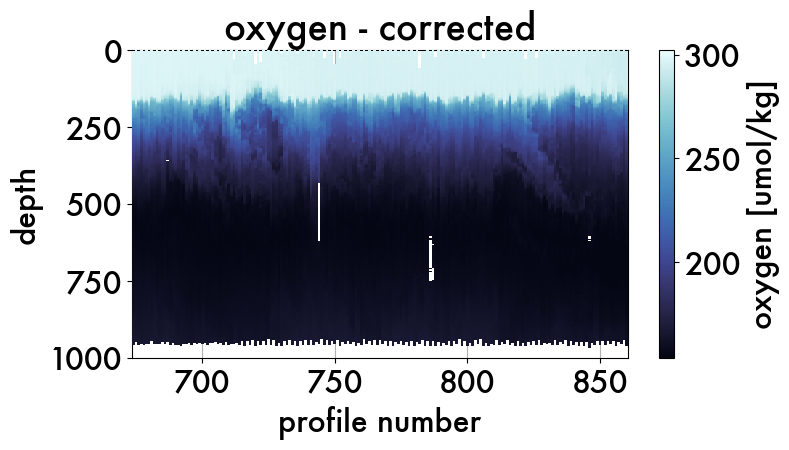

In [54]:
g3 = gproc.trim(gp_659, 180,200)
# g3 = gp_659
v= 'oxygen'

fig = plt.figure(figsize=(8,4))
ax = fig.gca()

min =  150
max =  320
# c = cmo.matter
g3[v].plot(cmap=cmo.ice, ax=ax, zorder=3)

ax.margins(x=0.01)
ax.invert_yaxis()
ax.set_title('oxygen - corrected')
ax.set_xlabel('profile number')
# ax.set_ylabel('$\sigma$')
plt.grid(visible=True, axis='x', zorder=0)

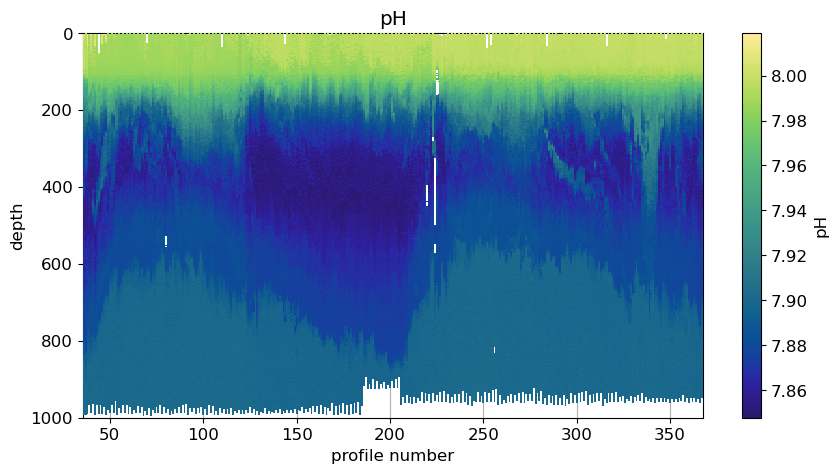

In [47]:
g3 = gproc.trim(gp_659, 140, 150)
# g3 = gp_659
v= 'pH'

fig = plt.figure(figsize=(10,5))
ax = fig.gca()

# min =  25
# max =  36
# c = cmo.matter
g3[v].plot(cmap=cmo.haline, ax=ax, zorder=3)

ax.margins(x=0.01)
ax.invert_yaxis()
ax.set_title('pH')
ax.set_xlabel('profile number')
# ax.set_ylabel('$\sigma$')
plt.grid(visible=True, axis='x', zorder=0)

In [29]:
gp_659

<xarray.Dataset>
Dimensions:     (depth: 1001, nprof: 912)
Coordinates:
  * nprof       (nprof) int64 0 1 2 3 4 5 6 7 ... 905 906 907 908 909 910 911
  * depth       (depth) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    time        (depth, nprof) datetime64[ns] 2019-04-30T13:58:31.250083328 ....
    dive        (nprof) int16 2 2 3 3 4 4 5 5 ... 459 460 460 461 461 462 462
    lat         (depth, nprof) float32 ...
    lon         (depth, nprof) float32 ...
    speed       (depth, nprof) float32 ...
    P           (depth, nprof) float32 ...
    SA          (depth, nprof) float32 ...
    CT          (depth, nprof) float32 ...
    oxygen_raw  (depth, nprof) float32 ...
    sigma       (depth, nprof) float64 nan 26.9 nan 26.9 nan ... nan nan nan nan
    days        (depth, nprof) float64 119.6 119.6 119.6 119.6 ... nan nan nan
    buoyancy    (depth, nprof) float64 nan 3.403e-05 nan ... nan nan nan
    secs        (depth, nprof) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    oxygen      (depth, nprof) float64 nan nan nan 294.3 nan ... nan nan nan nan
    pH          (depth, nprof) float64 nan nan nan 8.021 nan ... nan nan nan nan
    nitrate     (depth, nprof) float64 nan nan nan 25.82 nan ... nan nan nan nan
Attributes:
    id:                              sg659_level3
    time_coverage_resolution:        PT1S
    geospatial_vertical_units:       meter
    geospatial_vertical_resolution:  meter
    geospatial_vertical_positive:    no
    platform:                        glider
    geospatial_lat_units:            degrees
    geospatial_lat_resolution:       seconds
    geospatial_lon_units:            degrees
    geospatial_lon_resolution:       seconds
    institution:                     Applied Physics Lab, University of Washi...
    license:                         These data may be redistributed and used...
    keywords_vocabulary:             NASA/GCMD Earth Science Keywords Version...
    references:                      http://data.nodc.noaa.gov/accession/0092291
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Conventions:                     CF-1.6
    standard_name_vocabulary:        CF-1.6
    featureType:                     trajectoryProfile
    nodc_template_version:           NODC_NetCDF_Trajectory_Template_v0.9
    naming_authority:                edu.washington.apl
    creator_name:                    Luc Rainville
    creator_url:                     https://iop.apl.washington.edu
    creator_email:                   lucrain@uw.edu
    platform_id:                     SG659
    source:                          Seaglider SG659
    summary:                         SG659 SOGOS April 2019
    project:                         SOGOS April 2019
    glider:                          659
    mission:                         2
    seaglider_software_version:      66.12
    base_station_version:            3.0
    base_station_micro_version:      0
    quality_control_version:         1.12
    processing_level:                1.12
    instrument:                      aa4831 sbe41 wlbb2fl 
    title:                           Physical, chemical, and biological data ...
    keywords:                        Water Temperature, Conductivity, Salinit...
    geospatial_lon_min:              30.04640
    geospatial_lon_max:              67.79239
    geospatial_lat_min:              -53.45803
    geospatial_lat_max:              -45.64820
    time_coverage_start:             2019-04-30T13:58:31Z
    time_coverage_end:               2019-11-25T03:53:12Z
    time_coverage_duration:          P0000-00-208T13:54:40
    geospatial_vertical_min:         0.00
    geospatial_vertical_max:         1000.00
    date_created:                    2021-09-24T17:29:48Z
    date_modified:                   2021-09-24T17:29:48Z
    uuid:                            0440e19e-1d5d-11ec-9be7-acde48001122

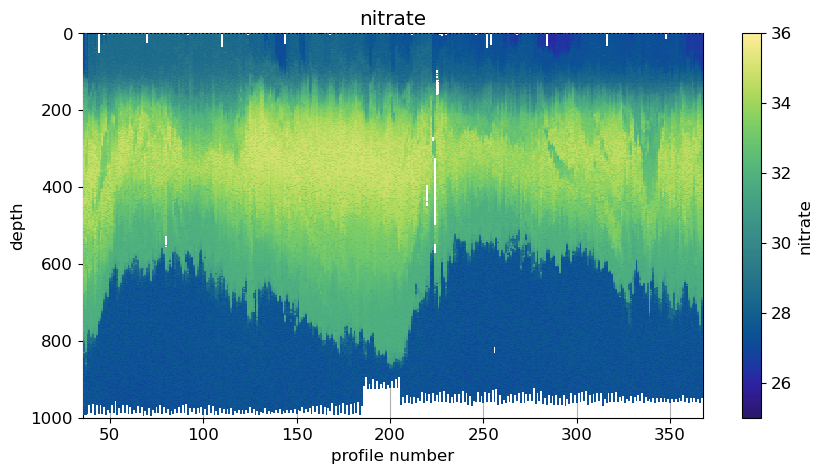

In [44]:
g3 = gproc.trim(gp_659, 123, 150)
# g3 = gp_659
v= 'nitrate'

fig = plt.figure(figsize=(10,5))
ax = fig.gca()

min =  25
max =  36
c = cmo.matter
g3[v].plot(vmin=min, vmax=max, cmap=cmo.haline, ax=ax, zorder=3)

ax.margins(x=0.01)
ax.invert_yaxis()
ax.set_title('nitrate')
ax.set_xlabel('profile number')
# ax.set_ylabel('$\sigma$')
plt.grid(visible=True, axis='x', zorder=0)


## 1.2 Add ESPER Alkalinity
- Brendan Carter MATLAB code for ESPER/LIAR
- More details in `ESPER-main/sogos_ESPER.mat`

In [ ]:
importlib.reload(dfproc)

In [18]:
# Export to MATLAB to run ESPER alkalinity algorithm on it

dfproc.DF2mat(df_659, (file_path + 'df659_forESPER_1013.mat'))
dfproc.DF2mat(df_660, (file_path + 'df660_forESPER_1013.mat'))


Saved to /Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/df659_forESPER_1013.mat
Saved to /Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/df660_forESPER_1013.mat


In [ ]:
# MATLAB CODE adapted from ESPER GITHUB

# load('/Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/df659_forESPER.mat')


# DesiredVariables = [1];
# OutputCoordinates = [double(lon'), double(lat'), double(depth)'];
# PredictorMeasurements = [double(sal'), double(temp'), double(oxygen')];
# PredictorTypes = [1 2 6];     % sal, temp, o2 (nitrate would be 4) = Eq. 7 S, T, B=Oxygen

# [Estimates, Uncertainties] = ESPER_Mixed(DesiredVariables, OutputCoordinates, PredictorMeasurements, 
#                                         PredictorTypes,'Equations',[7]);


# writematrix(Estimates.TA,'659-TA.csv')
# writematrix(Estimates.TA,'660-TA.csv')
# writematrix(Uncertainties.TA,'659-TA_uncert.csv')
# writematrix(Uncertainties.TA,'660-TA_uncert.csv')


In [51]:
# Read in MATLAB ESPER output
ta659 = pd.read_csv('/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/ESPER-main/659-TA-0910.csv', header=None)
ta660 = pd.read_csv('/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/ESPER-main/660-TA-0910.csv', header=None)

df_659['TA'] = ta659.values
df_660['TA'] = ta660.values

gp_659['TA'] = dfproc.dfvar_to_darray(df_659, 'TA')
gp_660['TA'] = dfproc.dfvar_to_darray(df_660, 'TA')

ValueError: Length of values (863036) does not match length of index (862039)

In [ ]:
file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/'
gp_659.to_netcdf(file_path + 'gp_659_0910.nc')
gp_660.to_netcdf(file_path + 'gp_660_0910.nc')

In [ ]:
file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/'
df_659.to_csv(file_path + 'df_659_0910.csv')
df_660.to_csv(file_path + 'df_660_0910.csv')

# 2. Transform in Density Space


In [79]:
importlib.reload(gproc)

<module 'sgmod_L3proc' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS/scripts/sgmod_L3proc.py'>

In [80]:
iso_659 = np.linspace(26.8,27.8,1001)  
gi_659 = gproc.transform_dataset(gp_659, iso_659, vars = ['SA', 'CT', 'oxygen', 'P', 'buoyancy']) 

iso_660 = np.linspace(26.9,28.0,1001)
gi_660 = gproc.transform_dataset(gp_660, iso_660,  vars = ['SA', 'CT', 'oxygen', 'P', 'buoyancy'])

In [81]:
gi_660

<xarray.Dataset>
Dimensions:   (nprof: 1008, sigma: 1001)
Coordinates:
  * sigma     (sigma) float64 26.9 26.9 26.9 26.9 26.9 ... 28.0 28.0 28.0 28.0
  * nprof     (nprof) int64 0 1 2 3 4 5 6 ... 1007 1008 1009 1010 1011 1012 1013
Data variables:
    time      (sigma, nprof) datetime64[ns] NaT ... NaT
    days      (sigma, nprof) float64 nan 119.5 nan 119.6 nan ... nan nan nan nan
    lat       (sigma, nprof) float32 nan -51.49 nan -51.48 ... nan nan nan nan
    lon       (sigma, nprof) float32 nan 30.03 nan 30.06 nan ... nan nan nan nan
    dive      (nprof) int16 1 1 2 2 3 3 4 4 ... 506 506 507 507 508 508 509 509
    SA        (sigma, nprof) float64 nan nan nan nan nan ... nan nan nan nan nan
    CT        (sigma, nprof) float64 nan nan nan nan nan ... nan nan nan nan nan
    oxygen    (sigma, nprof) float64 nan nan nan nan nan ... nan nan nan nan nan
    P         (sigma, nprof) float64 nan nan nan nan nan ... nan nan nan nan nan
    buoyancy  (sigma, nprof) float64 nan nan nan nan nan ... nan nan nan nan nan
    AOU       (sigma, nprof) float64 nan nan nan nan nan ... nan nan nan nan nan

In [82]:
file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/'
gi_659.to_netcdf(file_path + 'gi_659_forMLGeo1026.nc')
gi_660.to_netcdf(file_path + 'gi_660_forMLGeo1026.nc')

In [ ]:
iso_659 = np.linspace(26.8,27.8,1001)  
gi_659 = gproc.transform_dataset(gp_659, iso_659) 

iso_660 = np.linspace(26.9,28.0,1001)
gi_660 = gproc.transform_dataset(gp_660, iso_660)

gi_659['pH'] = gproc.transform_var(gp_659, iso_659, 'pH')
gi_660['pH'] = gproc.transform_var(gp_660, iso_660, 'pH')


In [ ]:
# file_path = '/Users/sangminsong/OneDrive - UW/Code/SOGOS/gridded-vars/'
# gi_659.to_netcdf(file_path + 'gi_659_0910.nc')
# gi_660.to_netcdf(file_path + 'gi_660_0910.nc')

# 3. Dive-averaged MLD

### Note that gp remains uncorrected for temperature and salinity. 

- Use only for latitude longitude information 

In [97]:
# Initial APL Glider data
file_path = '/Users/sangminsong/OneDrive-UW/Code/SOGOS-ML/data/seaglider-APL/'
L3_659 = xr.open_dataset(file_path + 'sg659_level3.nc')
L3_660 = xr.open_dataset(file_path + 'sg660_level3.nc')

In [99]:
dav_659 = gproc.simplify_dive_grid(L3_659, gp_659)
dav_660 = gproc.simplify_dive_grid(L3_660, gp_660)
# df_659 = dfproc.flatten2DF(gp_659)
# df_660 = dfproc.flatten2DF(gp_660)


# dav_659.to_netcdf(file_path + 'dav_659_0910.nc')

In [162]:
df_659 = pd.read_csv('../working-vars/glider/df_659_tsO2corr_0920.csv', index_col=0)
df_660 = pd.read_csv('../working-vars/glider/df_660_tsO2corr_0920.csv', index_col=0)


In [163]:
df_660

juld     yearday      lat      lon  pressure  \
4032    2019-04-30 12:14:50.707000064  119.510309 -51.4954  30.0251     4.035   
5040    2019-04-30 12:14:55.707000064  119.510367 -51.4953  30.0251     5.044   
6048    2019-04-30 12:15:00.707000064  119.510425 -51.4953  30.0252     6.053   
7056    2019-04-30 12:15:08.206500096  119.510512 -51.4953  30.0252     7.062   
8064    2019-04-30 12:15:15.707000064  119.510598 -51.4952  30.0253     8.070   
...                               ...         ...      ...      ...       ...   
966671  2019-07-25 20:57:50.200000000  205.873498 -51.5287  39.0112   968.672   
967679  2019-07-25 20:57:40.200499968  205.873382 -51.5287  39.0112   969.685   
968687  2019-07-25 20:57:30.200000000  205.873266 -51.5287  39.0112   970.699   
969695  2019-07-25 20:57:22.700999936  205.873179 -51.5288  39.0111   971.712   
970703  2019-07-25 20:57:15.200499968  205.873093 -51.5288  39.0111   972.726   

              CT        SA      oxygen      buoyancy   bbp_700  depth  \
4032    3.653773  33.96022  326.859426 -1.051859e-06  0.000283      4   
5040    3.649773  33.96122  327.084300 -1.051859e-06  0.000207      5   
6048    3.650773  33.96022  327.267310 -1.181382e-05  0.000193      6   
7056    3.648773  33.95822  327.392493 -8.461052e-06  0.000283      7   
8064    3.646773  33.95822  327.518402  2.355395e-05  0.000227      8   
...          ...       ...         ...           ...       ...    ...   
966671  2.114773  34.87422  182.209926  3.746761e-06       NaN    958   
967679  2.114773  34.87522  182.221260  3.746761e-06       NaN    959   
968687  2.114773  34.87522  182.230071  0.000000e+00       NaN    960   
969695  2.114773  34.87522  182.271982  3.737237e-06       NaN    961   
970703  2.114773  34.87622  182.310706 -9.538622e-09       NaN    962   

         profid  dive     sigma0     spice         AOU       o2sat  \
4032    6600000     1  27.013210 -0.409161   -6.502479  320.356948   
5040    6600000     1  27.014391 -0.408886   -6.698717  320.385583   
6048    6600000     1  27.013503 -0.409485   -6.887058  320.380252   
7056    6600000     1  27.012116 -0.411114   -6.991729  320.400764   
8064    6600000     1  27.012310 -0.411330   -7.102091  320.416311   
...         ...   ...        ...       ...         ...         ...   
966671  6601013   509  27.876441  0.081985  148.184300  330.394226   
967679  6601013   509  27.877237  0.082687  148.170391  330.391651   
968687  6601013   509  27.877237  0.082687  148.161583  330.391654   
969695  6601013   509  27.877237  0.082687  148.119676  330.391657   
970703  6601013   509  27.878033  0.083389  148.078376  330.389083   

        log_buoyancy  
4032             NaN  
5040             NaN  
6048             NaN  
7056             NaN  
8064      -10.656217  
...              ...  
966671    -12.494619  
967679    -12.494619  
968687          -inf  
969695    -12.497164  
970703           NaN  

[947968 rows x 18 columns]

### Holte Talley (outdated)

In [133]:
!pip install holteandtalley

  Preparing metadata (setup.py) ... done
  Created wheel for holteandtalley: filename=holteandtalley-0.0.3-py3-none-any.whl size=8050 sha256=35bcbd89a269edfea2d8821356212d16b24e2db2b0ff96a6ccf3d50d526425ce
  Stored in directory: /Users/sangminsong/Library/Caches/pip/wheels/51/2e/13/c6b2fa730f23de0f2c293f34de8289ac9777dec2df46989f62
Successfully built holteandtalley


In [164]:
# prof_list = dfproc.list_profile_DFs(df_660)
from holteandtalley import HolteAndTalley

avprof_660 = pd.DataFrame()
avprof_660['profid'] = pd.unique(df_660.profid)
avprof_660['yearday'] = [x.yearday.mean() for x in dfproc.list_profile_DFs(df_660)]


tempMLD=[]
salMLD=[]
densMLD = []
for prof in dfproc.list_profile_DFs(df_660):

    p = prof.pressure.values
    CT = prof.CT.values
    SA = prof.SA.values
    dens = prof.sigma0.values

    depth = HolteAndTalley(p, CT, SA, dens)
    tempMLD.append(depth.tempMLD)
    salMLD.append(depth.salinityMLD)
    densMLD.append(depth.densityMLD)
    # depth = gsw.mlp(prof.SA, prof.CT, prof.pressure)
    # avprof_660.loc[avprof_660.profid == prof.profid[0], 'mld'] = depth


In [165]:
avprof_660['tempMLD'] = tempMLD
avprof_660['salMLD'] = salMLD
avprof_660['densMLD'] = densMLD

In [167]:
avprof_660

profid     yearday     tempMLD   salMLD  densMLD
0     6600000  119.511780   15.132000   12.106   12.106
1     6600001  119.520366   10.088000  -79.500  -79.500
2     6600002  119.545467   11.097000   11.097    6.053
3     6600003  119.554565   12.106000   11.097    4.035
4     6600004  119.578766  131.183000   31.275   31.275
...       ...         ...         ...      ...      ...
999   6601009  205.481078  238.652875  151.500  151.500
1000  6601010  205.599204  220.033000   64.572  150.500
1001  6601011  205.700562  168.536000  136.500  136.500
1002  6601012  205.819388  176.613000  140.500  140.500
1003  6601013  205.925630  166.517000   99.500   99.500

[1004 rows x 5 columns]

In [168]:
avprof_659

profid     tempMLD   salMLD  densMLD     yearday
0    6590000   13.115000  -75.500  -75.500  119.584854
1    6590001   14.123000 -128.500 -128.500  119.592929
2    6590002   95.856000   66.590   47.418  119.619746
3    6590003   56.499000   46.409   50.445  119.632137
4    6590004  109.986000   69.000   69.000  119.689095
..       ...         ...      ...      ...         ...
907  6590907  174.597000  118.500  118.500  205.591899
908  6590908  176.616000  145.500  145.500  205.704500
909  6590909  171.568000  146.000  138.252  205.807137
910  6590910  154.382534  142.000  141.281  205.921728
911  6590911  188.858256  137.500  137.500  206.027143

[912 rows x 5 columns]

Text(0.5, 1.0, 'Glider 660 - Comparing Holte/Talley MLDs')

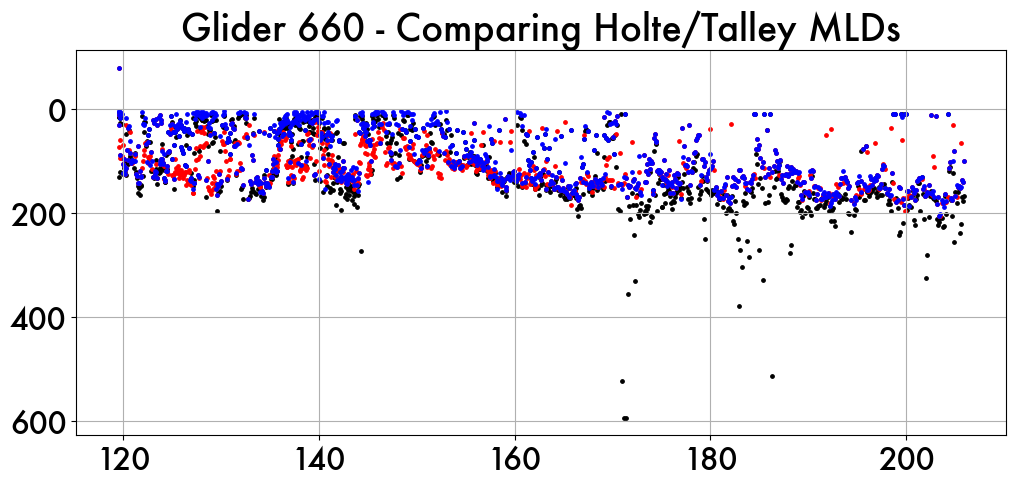

In [182]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

dat=avprof_660
ax.scatter(dat.yearday, dat.tempMLD, color='k', label='temp', s=6)
ax.scatter(dat.yearday, dat.salMLD, color='r', label='sal', s=6)
ax.scatter(dat.yearday, dat.densMLD, color='b', label='dens', s=6)
ax.invert_yaxis()
ax.grid(zorder=1)

plt.title('Glider 660 - Comparing Holte/Talley MLDs')


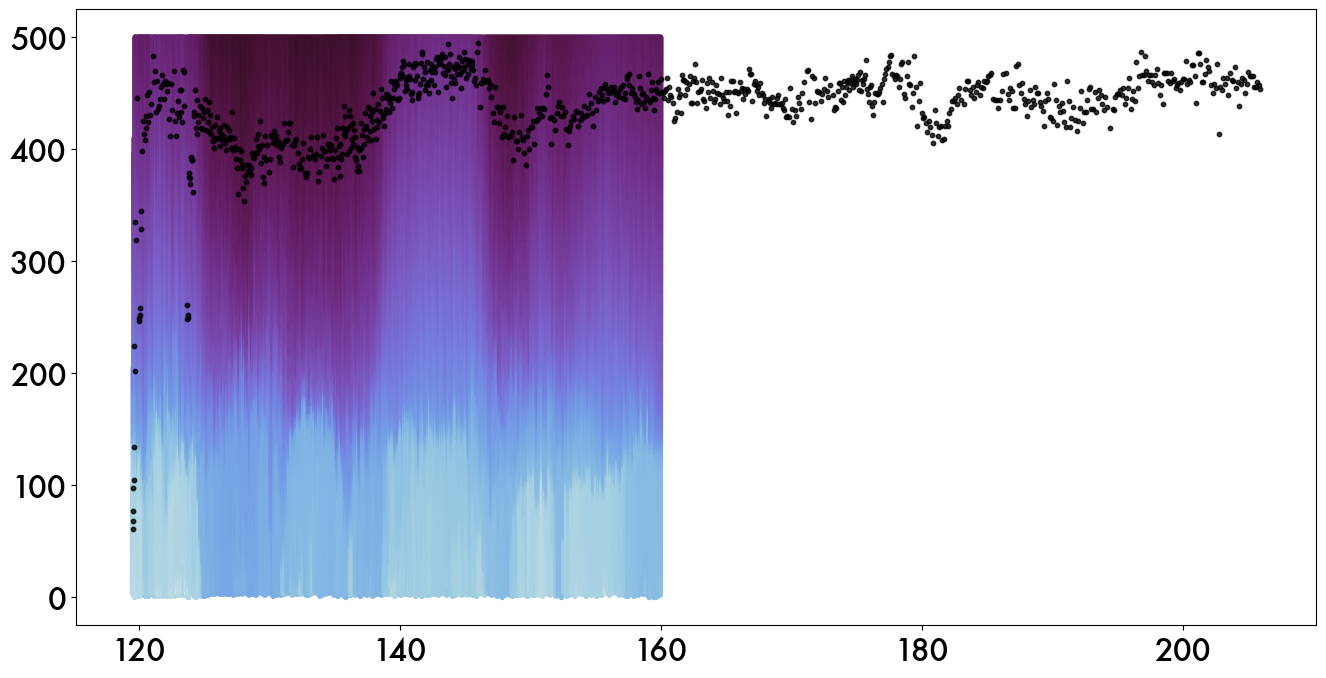

(120.0, 160.0)

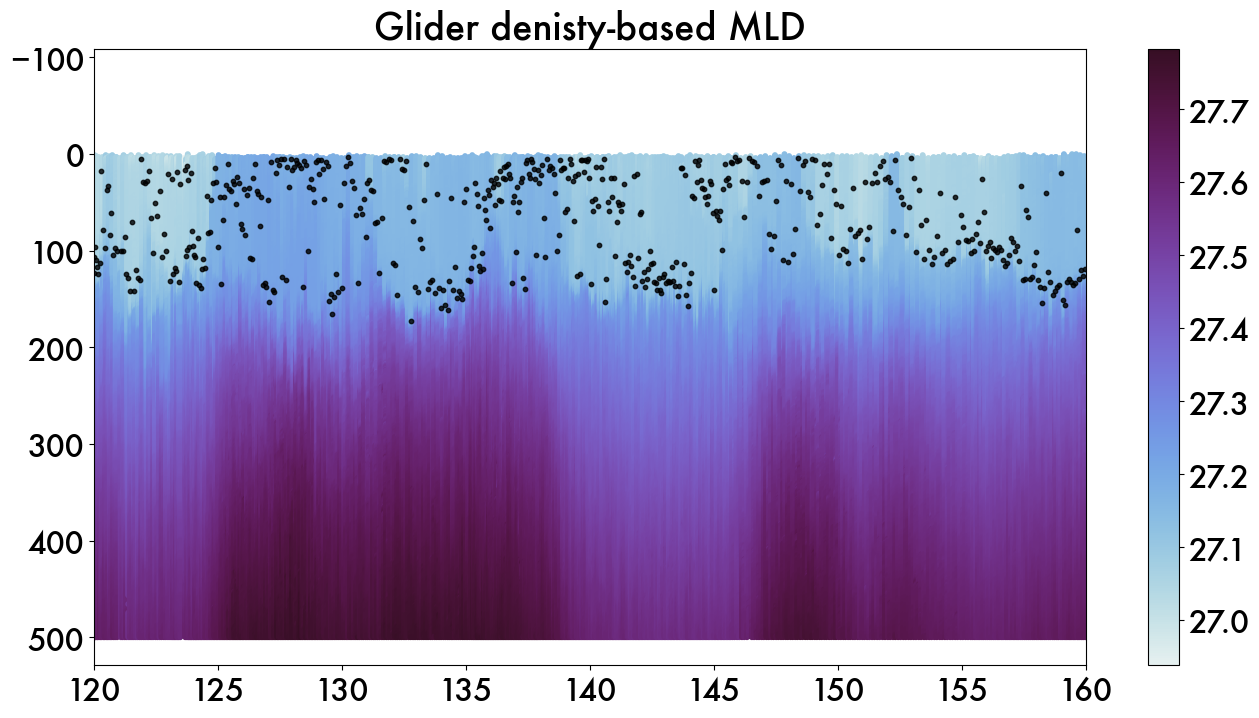

In [185]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()

# df_glid=df_660
dat = df_glid[df_glid.pressure<500]
dat = dat[dat.yearday<160]

mlpres = avprof_660
mlpres = mlpres[mlpres.yearday<160]

# map = ax.scatter(dat.yearday, dat.pressure, c=dat.nitrate_28t, cmap=cmo.deep, s=10)

map = ax.scatter(dat.yearday, dat.pressure, c=dat.sigma0, cmap=cmo.dense, s=10)
ax.scatter(mlpres.yearday, mlpres.densMLD, c='k', s=10, label='density', alpha=0.8)

# map = ax.scatter(dat.yearday, dat.pressure, c=dat.CT, cmap=cmo.thermal, s=10)
# ax.scatter(mlpres.yearday, mlpres.tempMLD, c='b', s=10, label='temp', alpha=0.8)

# map = ax.scatter(dat.yearday, dat.pressure, c=dat.SA, cmap=cmo.haline, s=10)
# ax.scatter(mlpres.yearday, mlpres.salMLD, c='w', s=10, label='salinity', alpha=0.8)

ax.set_title('Glider denisty-based MLD')
ax.invert_yaxis()
plt.colorbar(map)
# ax1 = ax.twiny()
# ax.scatter(mlpres.yearday, mlpres.tempMLD, c='r', s=20)

ax.set_xlim([120,160])


(array([150., 128.,  71.,  71., 106., 132., 193.,  87.,  33.,  12.,   5.,
          6.,   1.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   2.]),
 array([ 10.088  ,  33.40868,  56.72936,  80.05004, 103.37072, 126.6914 ,
        150.01208, 173.33276, 196.65344, 219.97412, 243.2948 , 266.61548,
        289.93616, 313.25684, 336.57752, 359.8982 , 383.21888, 406.53956,
        429.86024, 453.18092, 476.5016 , 499.82228, 523.14296, 546.46364,
        569.78432, 593.105  ]),
 <BarContainer object of 25 artists>)

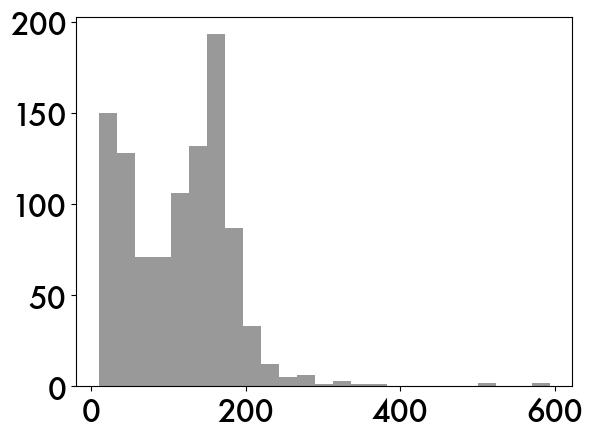

In [179]:
plt.hist(dat.tempMLD, bins=25, color='k', alpha=0.4, label="temp")

In [174]:
avprof_659.to_csv('../working-vars/glider/mld_659_0927.csv')


In [175]:
avprof_660.to_csv('../working-vars/glider/mld_660_0927.csv')

# NEW: Make MLD, dive-averaged

The MLD was defined by a density difference criteria of 0.05 kg m−3 from a 10-m reference level. 

In [318]:
def make_avprof(df):
    newDF = pd.DataFrame()
    newDF['profid'] = pd.unique(df.profid)
    newDF['yearday'] = [x.yearday.mean() for x in dfproc.list_profile_DFs(df)]
    newDF['lat'] = [x.lat.mean() for x in dfproc.list_profile_DFs(df)]
    newDF['lon'] = [x.lon.mean() for x in dfproc.list_profile_DFs(df)]

    prof_list = dfproc.list_profile_DFs(df)
    pressure=[]
    
    no10counter = 0
    lenrangesig = []

    for prof in prof_list:
        prof = prof.sort_values(by='pressure')

        temp10 = prof[(prof.pressure>9) & (prof.pressure<11)]
        if len(temp10)>0:
            dens10m = temp10.sigma0.values.mean()
            dens_tofind = dens10m + 0.05 # threshold used in dove 2021

            thresh=0.002
            rangesig = pd.DataFrame()
            rangesig = prof[(prof.sigma0 < (dens_tofind + thresh)) & (prof.sigma0 > (dens_tofind-thresh))].copy()
            lenrangesig.append(len(rangesig))
            pres = rangesig.pressure.median()

        else: 
            no10counter=no10counter+1
            pres = np.nan

        pressure.append(pres)
    newDF['mld'] = pressure
    print('number of profiles with no 10m data: ', no10counter)
    print('approx # of obs within profile that were averaged for final mlp: ', np.mean(lenrangesig))

    return newDF

In [258]:
prof_list = dfproc.list_profile_DFs(df_660)

for prof in prof_list[10:101:10]:
    prof = prof.sort_values(by='pressure')

    # Temporary df to make sure there is a value at 10m.
    temp10 = prof[(prof.pressure>9.5) & (prof.pressure<10.5)]
    if len(temp10)>0:
        # Reference density at 10m
        dens10m = temp10.sigma0.values.mean()
        dens_tofind = dens10m + 0.05 # threshold used in dove 2021

        thresh=0.002
        rangesig = pd.DataFrame()
        rangesig = prof[(prof.sigma0 < (dens_tofind + thresh)) & (prof.sigma0 > (dens_tofind-thresh))].copy()
        print(len(rangesig))
        pres = rangesig.pressure.median()


        # index_closestsig = np.argmin(np.abs(np.array(prof.sigma0) - dens_tofind))
        # pres = np.array(prof.pressure)[index_closestsig]


        # print(pres)
    else: 
        pres = np.nan

    #     pressure.append(pres)
    # newDF['mld'] = pressure


2
4
7
4
2
1
0
3


In [319]:
mld_659 = make_avprof(df_659)

number of profiles with no 10m data:  40
approx # of obs within profile that were averaged for final mlp:  1.6995412844036697


In [320]:
mld_660 = make_avprof(df_660)

number of profiles with no 10m data:  38
approx # of obs within profile that were averaged for final mlp:  2.0062111801242235


Text(0, 0.5, 'pressure')

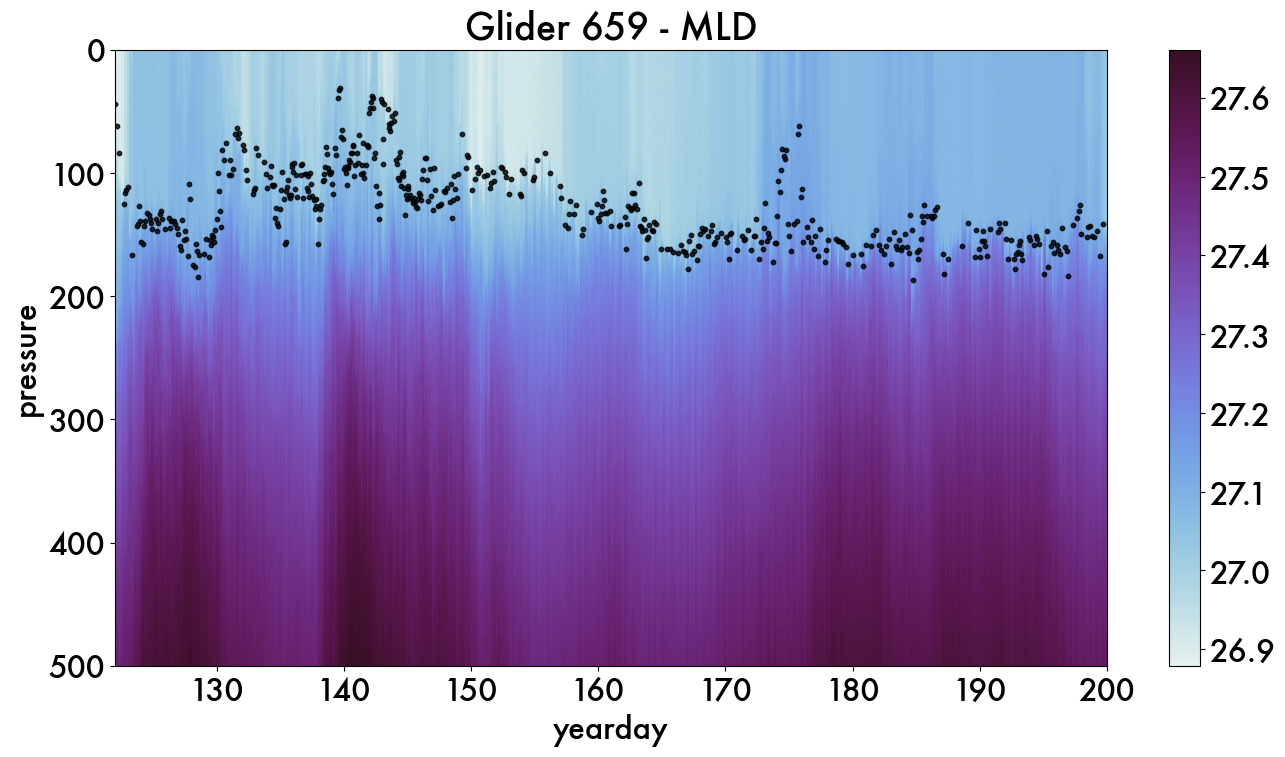

In [323]:
# Plot nitrate profile with MLD
fig = plt.figure(figsize=(16,8))
ax = fig.gca()

df_glid = df_659
dat = df_glid[df_glid.pressure<500]
dat = dat[(dat.yearday>122) & (dat.yearday<200)]

mlpres  = mld_659
mlpres = mlpres[(mlpres.yearday>122) & (mlpres.yearday<200)]

map = ax.scatter(dat.yearday, dat.pressure, c=dat.sigma0, cmap=cmo.dense, s=10)
plt.colorbar(map)

ax.invert_yaxis()
ax.set_xlim([122,200])
ax.set_ylim([500, 0])

ax.scatter(mlpres.yearday, mlpres.mld, c='k', s=10, label='dens 0.05', alpha=0.8)
ax.set_title('Glider 659 - MLD')
ax.set_xlabel('yearday')
ax.set_ylabel('pressure')

In [322]:
mld_659.to_csv('../working-vars/glider/mld_659_0927.csv')
mld_660.to_csv('../working-vars/glider/mld_660_0927.csv')

In [ ]:
-51.0 -50.99
lon
(depth, nprof)
float32
32.76 32.76




-50.98 -50.98
lon
(depth, nprof)
float32
32.76 32.76

In [40]:
gp_660.where((gp_659.dive==101), drop=True)

<xarray.Dataset>
Dimensions:     (depth: 1001, nprof: 2)
Coordinates:
  * nprof       (nprof) int64 194 195
  * depth       (depth) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables: (12/13)
    time        (depth, nprof) datetime64[ns] 1970-01-01 ... 1970-01-01
    dive        (nprof) float64 100.0 100.0
    lat         (depth, nprof) float32 nan -50.91 nan -50.91 ... nan nan nan nan
    lon         (depth, nprof) float32 nan 33.31 nan 33.31 ... nan nan nan nan
    speed       (depth, nprof) float32 nan nan nan 0.0 nan ... nan nan nan nan
    P           (depth, nprof) float32 nan 0.0 nan 1.009 ... nan nan nan nan
    ...          ...
    CT          (depth, nprof) float32 nan nan nan nan nan ... nan nan nan nan
    oxygen_raw  (depth, nprof) float32 nan nan nan nan nan ... nan nan nan nan
    sigma       (depth, nprof) float64 nan nan nan nan nan ... nan nan nan nan
    days        (depth, nprof) float64 nan 132.6 nan 132.6 ... nan nan nan nan
    buoyancy    (depth, nprof) float64 nan nan nan nan nan ... nan nan nan nan
    oxygen      (depth, nprof) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/49)
    id:                              sg660_level3
    time_coverage_resolution:        PT1S
    geospatial_vertical_units:       meter
    geospatial_vertical_resolution:  meter
    geospatial_vertical_positive:    no
    platform:                        glider
    ...                              ...
    time_coverage_duration:          P0000-00-208T14:40:52
    geospatial_vertical_min:         0.00
    geospatial_vertical_max:         1000.00
    date_created:                    2021-09-24T17:43:21Z
    date_modified:                   2021-09-24T17:43:21Z
    uuid:                            e93b1778-1d5e-11ec-9f9a-acde48001122

In [44]:
dav_659.lat[30:32]

<xarray.DataArray 'lat' (dive: 2)>
array([-51.2806, -51.2971], dtype=float32)
Coordinates:
  * dive     (dive) int64 30 31
Attributes:
    description:            average latitude of the dive
    units:                  degrees_north
    coverage_content_type:  physicalMeasurement

In [43]:
dav_659.lon[30:32]

<xarray.DataArray 'lon' (dive: 463)>
array([30.053, 30.084, 30.153, ..., 66.324, 66.394, 66.465], dtype=float32)
Coordinates:
  * dive     (dive) int64 0 1 2 3 4 5 6 7 8 ... 455 456 457 458 459 460 461 462
Attributes:
    description:            average longitude of the dive
    units:                  degrees_east
    coverage_content_type:  physicalMeasurement

In [39]:
gp_660.where((gp_659.dive==101) & (gp_659.depth==30), drop=True).lon


39.198 between dive 1 and 2 

<xarray.DataArray 'lon' (depth: 1, nprof: 2)>
array([[33.3122, 33.3131]], dtype=float32)
Coordinates:
  * nprof    (nprof) int64 194 195
  * depth    (depth) int64 30
Attributes:
    description:            longitude of every sample point, from the flight ...
    units:                  degrees_east
    standard_name:          longitude
    coverage_content_type:  physicalMeasurement

In [14]:
print(np.nanmin(gp_659.where(gp_659.dive==100).lat))
print(np.nanmax(gp_659.where(gp_659.dive==100).lat))

-50.9966
-50.9886


In [ ]:
from geopy import distance
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(distance.distance(newport_ri, cleveland_oh).miles)
538.39044536

wellington = (-41.32, 174.81)
salamanca = (40.96, -5.50)
print(distance.distance(wellington, salamanca).km)
19959.6792674

In [19]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    # dlon = (lon1 - lon2) * np.pi / 180.0

    dlon = []
    for i in range(lon1.shape[0]):
        dlon.append(lon1[i].values-lon2[i].values)
    dlon = np.array(dlon) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [23]:
dist_659

array([4.3829677e-01, 3.1161195e-01, 5.7943244e-02, 1.5232033e-01,
       9.7101189e-02, 1.4757392e-01, 1.8426588e-01, 1.9730687e-01,
       1.5327336e-01, 8.1256554e-02, 7.4799821e-02, 2.3287393e-02,
       6.0057953e-02, 2.0736897e-02, 2.6766810e-01, 2.5279528e-01,
       1.8443587e-01, 6.1020404e-02, 3.5756975e-02, 3.4253236e-02,
       2.4153901e-02, 3.1519804e-02, 9.0431213e-02, 1.3241947e-01,
       5.6832653e-02, 1.1527688e-01, 1.7604576e-01, 4.0385348e-01,
       1.7583376e-01, 1.1479744e-01, 6.4495988e-02, 1.2892948e-01,
       1.7007184e-01, 1.8594769e-01, 2.1600793e-01, 3.0379412e-01,
       2.5515500e-01, 2.8321895e-01, 2.5397277e-01, 1.8876278e-01,
       1.7460702e-01, 1.2128055e-01, 1.1628322e-01, 9.7203583e-02,
       1.1620493e-01, 9.9580891e-02, 1.6183160e-01, 8.3582558e-02,
       9.7443730e-02, 1.8871337e-01, 9.4157837e-02, 3.8488038e-02,
       1.4376085e-01, 2.0332234e-01, 3.4152672e-01, 7.5753339e-02,
       1.4215337e-01, 9.5698968e-02, 4.5296293e-02, 1.3965284e

In [29]:
def daily_dist(dav):
    temp = dav.days.round()
    cind = []

    for i in np.arange(1,len(temp),1):
        if temp[i]-temp[i-1]>0:
            cind.append(i)

    la1 = dav.lat[cind[:-1]]
    lo1 = dav.lon[cind[:-1]]
    la2 = dav.lat[cind[1:]]
    lo2 = dav.lon[cind[1:]]

    dist = great_circle_distance(lo2, la2, lo1, la1)
    return dist

dist_659 = daily_dist(dav_659)
dist_660 = daily_dist(dav_660)

dist_659.mean()

0.36366016

Text(0.5, 1.0, '659 MLD distribution')

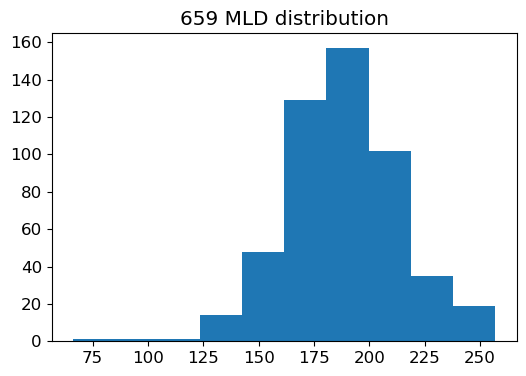

In [45]:
# g3 = gp_660
dav = dav_659
fig = plt.figure(figsize=(6,4))

mld = dav.mld.values
mld = mld[~np.isnan(mld)]
a,b = np.histogram(mld)
plt.hist(mld,bins=b)
plt.title('659 MLD distribution')

# Figures

In [ ]:
function pres = sw_pres(DEPTH,LAT)

% SW_PRES    Pressure from depth
%===========================================================================
% SW_PRES   $Id: sw_pres.m,v 1.1 2003/12/12 04:23:22 pen078 Exp $
%           Copyright (C) CSIRO, Phil Morgan 1993.
%
% USAGE:  pres = sw_pres(depth,lat)
%
% DESCRIPTION:
%    Calculates pressure in dbars from depth in meters.
%
% INPUT:  (all must have same dimensions)
%   depth = depth [metres]
%   lat   = Latitude in decimal degress north [-90..+90]
%           (LAT may have dimensions 1x1 or 1xn where depth(mxn) )
%
% OUTPUT:
%  pres   = Pressure    [db]
%
% AUTHOR:  Phil Morgan 93-06-25  (morgan@ml.csiro.au)
%
% DISCLAIMER:
%   This software is provided "as is" without warranty of any kind.
%   See the file sw_copy.m for conditions of use and licence.
%
% REFERENCES:
%    Saunders, P.M. 1981
%    "Practical conversion of Pressure to Depth"
%    Journal of Physical Oceanography, 11, 573-574
%
% CHECK VALUE:
%    P=7500.00 db for LAT=30 deg, depth=7321.45 meters
%=========================================================================

% Modifications
% 99-06-25. Lindsay Pender, Fixed transpose of row vectors.

% CALLER:  general purpose
% CALLEE:  none

%-------------
% CHECK INPUTS
%-------------
[mD,nD] = size(DEPTH);
[mL,nL] = size(LAT);
if mL==1 & nL==1                    % LAT scalar - fill to size of P
  LAT = LAT*ones(size(DEPTH));

elseif nD == nL & mL == 1           % LAT is row vector
  LAT = LAT(ones(1, mD), :);        % Coppy down each column

elseif mD == mL & nL == 1           % LAT is column vector
  LAT = LAT(:, ones(1, nD));        % Copy across each row

elseif mD == mL & nD == nL
  % Ok

else
   error('sw_pres.m:  Inputs arguments have wrong dimensions')
end %if

%-------------
% BEGIN
%-------------

DEG2RAD = pi/180;
X       = sin(abs(LAT)*DEG2RAD);  % convert to radians
C1      = 5.92E-3+X.^2*5.25E-3;
pres    = ((1-C1)-sqrt(((1-C1).^2)-(8.84E-6*DEPTH)))/4.42E-6;
return
%===========================================================================



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff24006fef0> (for post_execute):


KeyboardInterrupt: 

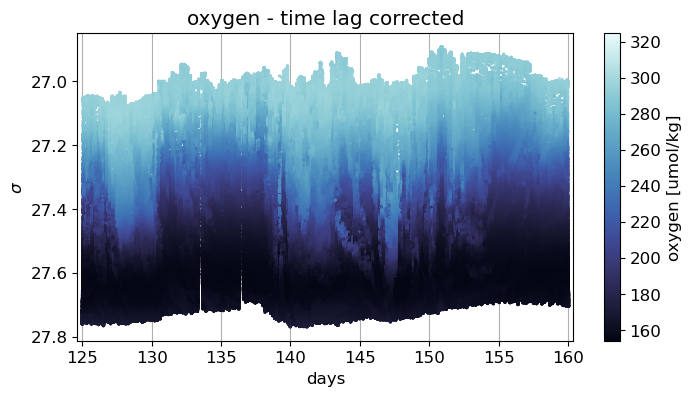

In [ ]:
# plot to check oxygen fixed
plot_var(gproc.trim(gp_659,135, 160), var='oxygen')

## BACK FROM NITRATE

In [82]:
df_659

juld     yearday        lat        lon  \
3648   2019-04-30 13:59:56.205999872  119.583289 -51.495300  30.047100   
4560   2019-04-30 13:59:58.707000064  119.583318 -51.495300  30.047100   
5472   2019-04-30 14:00:03.707000064  119.583376 -51.495201  30.047199   
6384   2019-04-30 14:00:06.206500096  119.583405 -51.495201  30.047199   
7296   2019-04-30 14:00:08.706000128  119.583434 -51.495201  30.047199   
...                              ...         ...        ...        ...   
864575 2019-07-25 23:22:37.200999936  205.974042 -51.706200  38.982101   
865487 2019-07-25 23:22:27.200999936  205.973926 -51.706200  38.982101   
866399 2019-07-25 23:22:17.200999936  205.973810 -51.706200  38.982101   
867311 2019-07-25 23:22:07.200999936  205.973694 -51.706200  38.982101   
868223 2019-07-25 23:21:57.200999936  205.973579 -51.706200  38.981998   

          pressure        CT         SA      oxygen      buoyancy   bbp_700  \
3648      4.035000  3.579758  33.992031  329.116731 -6.526437e-06  0.000229   
4560      5.044000  3.578758  33.991032  329.118250 -4.999368e-06  0.000223   
5472      6.053000  3.580758  33.991032  329.153605  3.170546e-06  0.000221   
6384      7.062000  3.581758  33.992031  329.761488  2.857285e-06  0.000220   
7296      8.070000  3.582758  33.992031  330.009182 -4.583818e-07  0.000225   
...            ...       ...        ...         ...           ...       ...   
864575  957.539001  2.163758  34.875034  180.973612  5.783918e-06       NaN   
865487  958.552979  2.162758  34.876034  181.023786  4.248624e-06       NaN   
866399  959.565979  2.162758  34.876034  181.070580  4.248337e-06       NaN   
867311  960.580017  2.161758  34.877033  181.114731  4.248337e-06       NaN   
868223  961.593018  2.161758  34.877033  181.139840  1.279869e-07       NaN   

        depth   profid  dive     sigma0     spice         AOU       o2sat  \
3648        4  6590000     2  26.904773 -0.528216   -8.261820  320.854911   
4560        5  6590000     2  26.904077 -0.529028   -8.253069  320.865181   
5472        6  6590000     2  26.903886 -0.528816   -8.304066  320.849539   
6384        7  6590000     2  26.904582 -0.528004   -8.922269  320.839220   
7296        8  6590000     2  26.904486 -0.527898   -9.177797  320.831386   
...       ...      ...   ...        ...       ...         ...         ...   
864575    947  6590911   462  27.730886 -0.045121  149.014392  329.988004   
865487    948  6590911   462  27.731762 -0.044509  148.969888  329.993675   
866399    949  6590911   462  27.731762 -0.044509  148.923098  329.993678   
867311    950  6590911   462  27.732639 -0.043898  148.884618  329.999349   
868223    951  6590911   462  27.732639 -0.043898  148.859512  329.999352   

        log_buoyancy  
3648             NaN  
4560             NaN  
5472      -12.661607  
6384      -12.765639  
7296             NaN  
...              ...  
864575    -12.060429  
865487    -12.368915  
866399    -12.368983  
867311    -12.368983  
868223    -15.871338  

[862039 rows x 18 columns]

In [ ]:
df_659 = df_659.sort_values(by='yearday')
np.diff(df_659.)